# 2018 Yellow Taxi Trip Data Analysis

- Importing python library
- Read taxi-sample and shape files
- Data cleaning (removing null values, trip duration 0 etc.)
- Insights on different attributes

In [1]:
import pandas as pd
import numpy as np
import time
import shapefile
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns
import math

### Loading taxi-sample data

In [2]:
startTime = time.time()
taxiSample = pd.read_csv("data/taxi-sample.csv")
taxiSample[105:110]

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
105         2  03/12/2019 11:12:48 PM  03/12/2019 11:23:38 PM   
106         2  03/07/2019 06:25:03 AM  03/07/2019 03:25:31 PM   
107         2  03/04/2019 12:35:59 PM  03/04/2019 01:07:03 PM   
108         2  03/04/2019 12:13:56 AM  03/04/2019 12:32:39 AM   
109         2  03/03/2019 03:27:20 AM  03/03/2019 12:01:14 PM   

     passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
105                1           1.10           1                  N   
106                1           8.66           1                  N   
107                2           5.52           1                  N   
108                5          11.94           1                  N   
109                1           6.37           1                  N   

     PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
105           137           113             1          8.5    0.0      0.5   
106           163            54             1         38.0    0.0      0.5   
107            50           179             1         23.0    0.0      0.5   
108            70           265             2         32.5    0.0      0.5   
109           170            13             1         27.0    0.0      0.5   

     tip_amount  tolls_amount  improvement_surcharge  total_amount  
105        1.86           0.0                    0.3         11.16  
106        7.76           0.0                    0.3         46.56  
107        0.00           0.0                    0.3         23.80  
108        0.00           0.0                    0.3         33.30  
109        4.50           0.0                    0.3         32.30

### Update datetime column to 24 hour format and adding columns for hour, week, month etc.

In [3]:
%%time
taxiSample['tpep_pickup_datetime'] = pd.to_datetime(taxiSample['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
taxiSample['tpep_dropoff_datetime'] = pd.to_datetime(taxiSample['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 7.35 s, sys: 36.6 ms, total: 7.39 s
Wall time: 7.17 s


In [4]:
taxiSample["pickup_date"] = taxiSample.tpep_pickup_datetime.dt.day
taxiSample["pickup_dayofweek"] = taxiSample.tpep_pickup_datetime.dt.weekday
taxiSample["pickup_weekday"] = taxiSample.tpep_pickup_datetime.dt.weekday_name
taxiSample["pickup_hour"] = taxiSample.tpep_pickup_datetime.dt.hour
taxiSample["pickup_month"] = taxiSample.tpep_pickup_datetime.dt.month
taxiSample["pickup_year"] = taxiSample.tpep_pickup_datetime.dt.year

In [5]:
taxiSample["dropoff_date"] = taxiSample.tpep_dropoff_datetime.dt.day
taxiSample["dropoff_weekday"] = taxiSample.tpep_dropoff_datetime.dt.weekday_name
taxiSample["dropoff_hour"] = taxiSample.tpep_dropoff_datetime.dt.hour
taxiSample["dropoff_month"] = taxiSample.tpep_dropoff_datetime.dt.month
taxiSample["dropoff_year"] = taxiSample.tpep_dropoff_datetime.dt.year

In [6]:
print(taxiSample.shape)
taxiSample[105:110]

(1048576, 28)


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
105         2  2019-03-12 23:12:48   2019-03-12 23:23:38                1   
106         2  2019-03-07 06:25:03   2019-03-07 15:25:31                1   
107         2  2019-03-04 12:35:59   2019-03-04 13:07:03                2   
108         2  2019-03-04 00:13:56   2019-03-04 00:32:39                5   
109         2  2019-03-03 03:27:20   2019-03-03 12:01:14                1   

     trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
105           1.10           1                  N           137           113   
106           8.66           1                  N           163            54   
107           5.52           1                  N            50           179   
108          11.94           1                  N            70           265   
109           6.37           1                  N           170            13   

     payment_type  ...  pickup_dayofweek  pickup_weekday  pickup_hour  \
105             1  ...                 1         Tuesday           23   
106             1  ...                 3        Thursday            6   
107             1  ...                 0          Monday           12   
108             2  ...                 0          Monday            0   
109             1  ...                 6          Sunday            3   

     pickup_month  pickup_year  dropoff_date  dropoff_weekday  dropoff_hour  \
105             3         2019            12          Tuesday            23   
106             3         2019             7         Thursday            15   
107             3         2019             4           Monday            13   
108             3         2019             4           Monday             0   
109             3         2019             3           Sunday            12   

     dropoff_month dropoff_year  
105              3         2019  
106              3         2019  
107              3         2019  
108              3         2019  
109              3         2019  

[5 rows x 28 columns]

### Loading shape file

In [7]:
taxiZonesShape = shapefile.Reader("data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in taxiZonesShape.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = taxiZonesShape.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

### Methods for displaying the map

In [8]:
def get_lat_lon(taxiZones):
    content = []
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [9]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [10]:
def draw_region_map(ax, taxiZones, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_x = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    reg_y = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values())))
        cm=plt.get_cmap('Reds')
    
    ax.set_facecolor(ocean)
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center',
                     verticalalignment='center', bbox=dict(facecolor='black', alpha=0.5),
                     color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000),
                     horizontalalignment='center', verticalalignment='center',
                     bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=12)       

    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [11]:
def draw_zone_map(ax, taxiZones, heat={}, text=[], arrows=[]):
    continent = [180/256, 50/256, 50/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values()))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=8,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [12]:
taxiZone = pd.DataFrame(shp_attr).join(get_lat_lon(taxiZonesShape).set_index("LocationID"), on="LocationID")
zone_dic = dict(zip(taxiZone.LocationID, taxiZone.zone))
borough_dic = dict(zip(taxiZone.LocationID, taxiZone.borough))
zones = taxiZone['zone'].unique()
boroughs = taxiZone['borough'].unique()
temp = dict(enumerate(boroughs.flatten(), 1))
reg_list = dict([(value, key) for key, value in temp.items()])
print(reg_list)
taxiZone.head()

{'EWR': 1, 'Queens': 2, 'Bronx': 3, 'Manhattan': 4, 'Staten Island': 5, 'Brooklyn': 6}


LocationID  OBJECTID  Shape_Area  Shape_Leng        borough  \
0           1         1    0.000782    0.116357            EWR   
1           2         2    0.004866    0.433470         Queens   
2           3         3    0.000314    0.084341          Bronx   
3           4         4    0.000112    0.043567      Manhattan   
4           5         5    0.000498    0.092146  Staten Island   

                      zone     longitude       latitude  
0           Newark Airport  9.366817e+05  190522.130278  
1              Jamaica Bay  1.033536e+06  161853.982300  
2  Allerton/Pelham Gardens  1.027136e+06  254730.010849  
3            Alphabet City  9.904240e+05  203100.040432  
4            Arden Heights  9.321332e+05  139954.541936

### Show the boroughs and zones of New York City

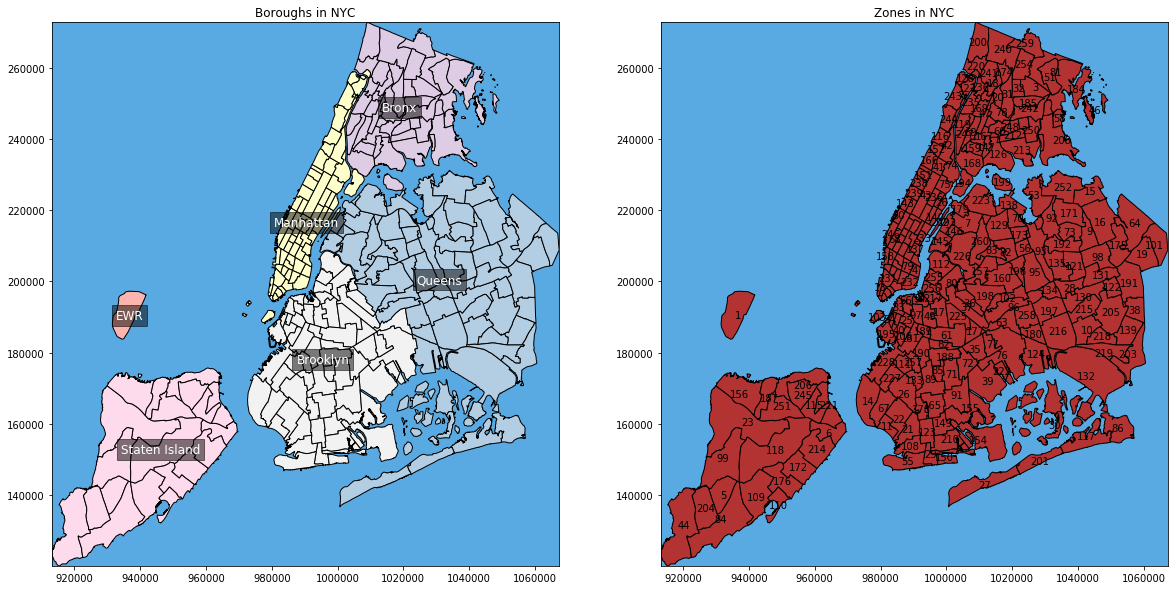

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, taxiZonesShape)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, taxiZonesShape)

## Data Cleaning

### Checking if there is any null value in the dataset

In [14]:
taxiSample.isnull().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag       False
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
pickup_date              False
pickup_dayofweek         False
pickup_weekday           False
pickup_hour              False
pickup_month             False
pickup_year              False
dropoff_date             False
dropoff_weekday          False
dropoff_hour             False
dropoff_month            False
dropoff_year             False
dtype: bool

### Removing rows with trip distance 0 or less

In [15]:
trip_dist = taxiSample[taxiSample.trip_distance <= 0.0]
trip_dist.shape

(8463, 28)

In [16]:
taxiSample = taxiSample[taxiSample.trip_distance > 0.0]
taxiSample.shape

(1040113, 28)

### Removing rows with passenger count 0 or less

In [17]:
pass_count = taxiSample[taxiSample.passenger_count <= 0]
pass_count.shape

(15039, 28)

In [18]:
taxiSample = taxiSample[taxiSample.passenger_count > 0]
taxiSample.shape

(1025074, 28)

### Removing duplicate rows

In [19]:
duplicate = taxiSample[taxiSample.duplicated()]
duplicate.shape

(21, 28)

In [20]:
taxiSample.drop_duplicates(keep='first', inplace=True)
taxiSample.shape

(1025053, 28)

### Removing rows with same pickup and dropoff time

In [21]:
same_pick_drop = taxiSample[taxiSample.tpep_pickup_datetime==taxiSample.tpep_dropoff_datetime]
same_pick_drop.shape

(46, 28)

In [22]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime!=taxiSample.tpep_dropoff_datetime]
taxiSample.shape

(1025007, 28)

### Removing rows with future dates

In [23]:
print("Train dataset start date: ", min(taxiSample["tpep_pickup_datetime"]))
print("Train dataset end date: ", max(taxiSample["tpep_dropoff_datetime"]))

Train dataset start date:  2018-12-27 00:05:14
Train dataset end date:  2084-11-04 12:47:41


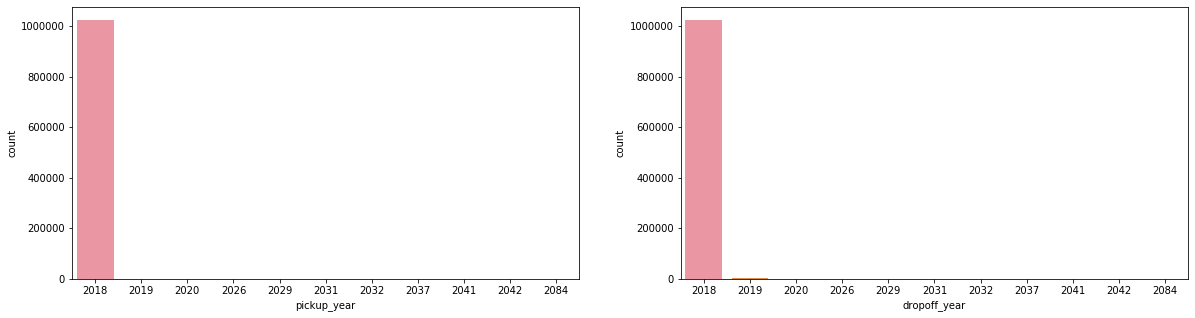

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

In [25]:
taxiSample.groupby('pickup_year')['pickup_year'].count()

pickup_year
2018    1024804
2019        175
2020         10
2026          2
2029          2
2031          2
2032          1
2037          1
2041          1
2042          1
2084          8
Name: pickup_year, dtype: int64

#### We are assuming limit for date is: "2019-06-30 23:59:59" and remove all the future dates

In [26]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime<="2019-06-30 23:59:59"]
taxiSample.shape

(1024969, 28)

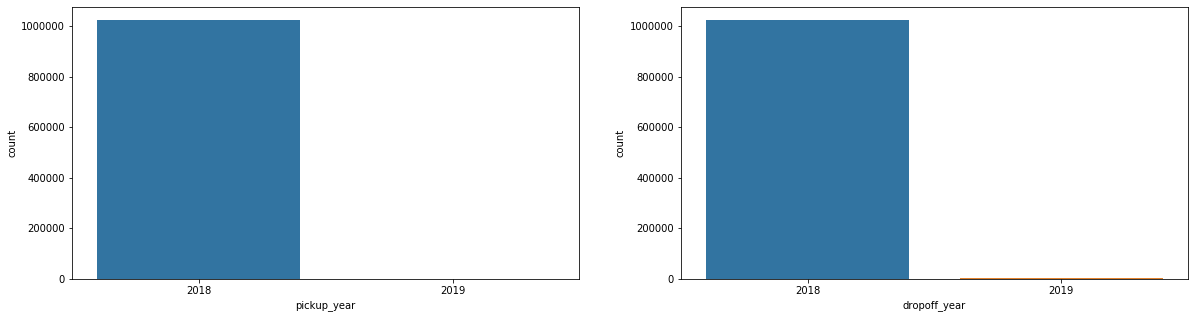

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

### Removing rows that have RatecodeID>6

In [28]:
ratecode_count = taxiSample.groupby('RatecodeID')['RatecodeID'].count()
ratecode_count

RatecodeID
1     991516
2      25862
3       1674
4        652
5       5253
6          2
99        10
Name: RatecodeID, dtype: int64

In [29]:
taxiSample = taxiSample[taxiSample.RatecodeID<=6]
taxiSample.shape

(1024959, 28)

### Checking amounts for negative or zero values

In [30]:
taxiSample[taxiSample.fare_amount<=0.0].shape

(1029, 28)

In [31]:
taxiSample[taxiSample.tip_amount<0.0].shape

(5, 28)

In [32]:
taxiSample[taxiSample.tolls_amount<0.0].shape

(17, 28)

In [33]:
taxiSample[taxiSample.total_amount<=0.0].shape

(902, 28)

In [34]:
taxiSample[taxiSample.extra<0.0].shape

(440, 28)

In [35]:
taxiSample[taxiSample.mta_tax<0.0].shape

(856, 28)

In [36]:
taxiSample[taxiSample.improvement_surcharge<0.0].shape

(871, 28)

In [37]:
taxiSample = taxiSample[taxiSample.fare_amount>0.0]
taxiSample = taxiSample[taxiSample.tip_amount>=0.0]
taxiSample = taxiSample[taxiSample.tolls_amount>=0.0]
taxiSample = taxiSample[taxiSample.total_amount>0.0]
taxiSample = taxiSample[taxiSample.extra>=0.0]
taxiSample = taxiSample[taxiSample.VendorID<=2]
taxiSample = taxiSample[taxiSample.mta_tax>=0.0]
taxiSample = taxiSample[taxiSample.improvement_surcharge>=0.0]
taxiSample.shape

(1011891, 28)

### Removing rows that has LocationID > 263 or < 1, as we don't have shape for those zones

In [38]:
taxiSample[taxiSample.PULocationID>263].shape

(16443, 28)

In [39]:
taxiSample[taxiSample.DOLocationID>263].shape

(17041, 28)

In [40]:
taxiSample = taxiSample[taxiSample.PULocationID<=263]

In [41]:
taxiSample = taxiSample[taxiSample.DOLocationID<=263]

# Insights on different attributes

## Vendor

### Which vendor is most popular overall?

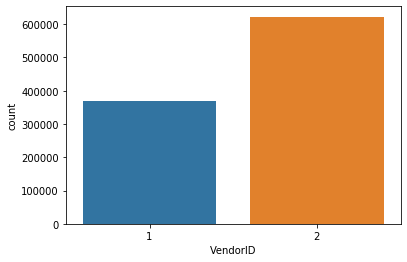

In [42]:
sns.countplot(x="VendorID", data=taxiSample)

In [43]:
taxiSample.groupby('VendorID')['VendorID'].count()

VendorID
1    370427
2    622408
Name: VendorID, dtype: int64

### Which Vendor is popular in each region?

          borough  VendorID   count
0           Bronx         1     581
1           Bronx         2    1624
2        Brooklyn         1    4250
3        Brooklyn         2    8425
4             EWR         1      14
5             EWR         2      12
6       Manhattan         1  341584
7       Manhattan         2  561923
8          Queens         1   24049
9          Queens         2   50588
10  Staten Island         1      10
11  Staten Island         2      40


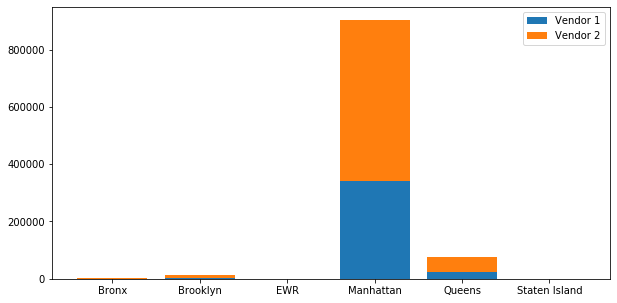

In [44]:
result = taxiSample.groupby(['VendorID','PULocationID'])['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','VendorID'])['count'].sum().reset_index(name='count')
print(groupResult)
vendor1 = groupResult[groupResult.VendorID==1]['count']
vendor2 = groupResult[groupResult.VendorID==2]['count']
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(groupResult['borough'].unique(), vendor1, label = "Vendor 1")
ax.bar(groupResult['borough'].unique(), vendor2, bottom=vendor1, label = "Vendor 2")
ax.legend()

## Passenger

### What is the most frequent passenger count?

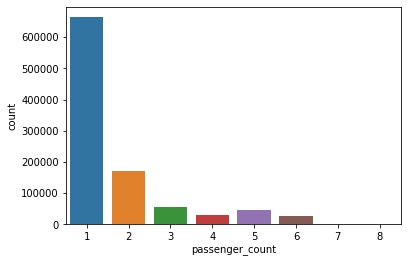

In [45]:
sns.countplot(x="passenger_count", data=taxiSample)

In [46]:
taxiSample.groupby('passenger_count')['passenger_count'].count()

passenger_count
1    663432
2    170907
3     54765
4     31652
5     44703
6     27373
7         1
8         2
Name: passenger_count, dtype: int64

## Store and Forward trip

### What is the percentage of store and forward trip?

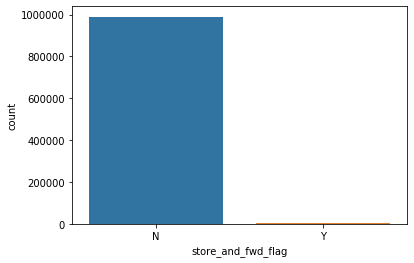

In [47]:
sns.countplot(x="store_and_fwd_flag", data=taxiSample)

In [48]:
taxiSample.groupby('store_and_fwd_flag')['store_and_fwd_flag'].count()

store_and_fwd_flag
N    989240
Y      3595
Name: store_and_fwd_flag, dtype: int64

Text(236, 162, 'Most Store and Forward')

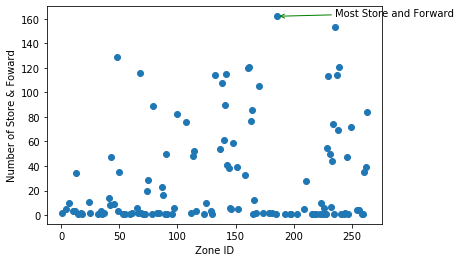

In [49]:
dataY = taxiSample[ taxiSample.store_and_fwd_flag=="Y"][['PULocationID','store_and_fwd_flag']]
datax = dataY.groupby("PULocationID").size()
datax = datax.rename('trips').reset_index()
plt.scatter(x="PULocationID",y="trips", data=datax)
plt.xlabel("Zone ID")
plt.ylabel("Number of Store & Foward")
maxv = datax.loc[datax['trips'].idxmax()]
maxx = maxv["PULocationID"]
maxy = maxv["trips"]
plt.annotate("Most Store and Forward", xy=(maxx,maxy), xytext=(maxx+50,maxy), arrowprops={"arrowstyle":"->","color":"green"})

In [50]:
temp_flag = taxiSample[taxiSample.store_and_fwd_flag=='N']
(temp_flag.shape[0]*100) / taxiSample.shape[0]  # percentage of record that are N

99.63790559357798

### Which region has the most store and forward trip?

{'EWR': 2, 'Queens': 272, 'Bronx': 15, 'Manhattan': 3250, 'Staten Island': 2, 'Brooklyn': 54}


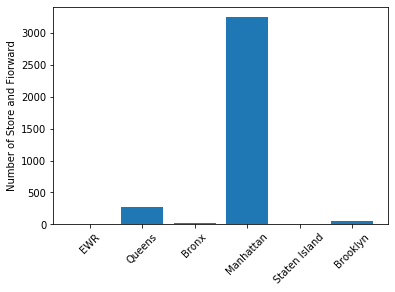

In [113]:
flagCount = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    flagCount[borough] = totalRideBorough[totalRideBorough.store_and_fwd_flag=='Y']['store_and_fwd_flag'].count()
print(flagCount)
plt.bar(range(len(flagCount)), list(flagCount.values()), align='center')
plt.xticks(range(len(flagCount)), list(flagCount.keys()), rotation=45)
plt.ylabel("Number of Store and Fiorward")
plt.show()

## Payment method

### What is the most popular payment method?

payment_type is a numeric code signifying how the passenger paid for the trip:

* 1=Credit card
* 2=Cash
* 3=No charge
* 4=Dispute

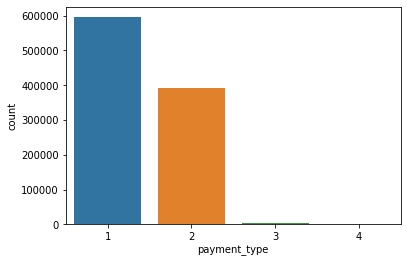

In [52]:
sns.countplot(x="payment_type", data=taxiSample)

In [53]:
taxiSample.groupby('payment_type')['payment_type'].count()

payment_type
1    595337
2    392138
3      3928
4      1432
Name: payment_type, dtype: int64

### Which Payment Type is popular in each region?

          borough  payment_type   count
0           Bronx             1    1521
1           Bronx             2     663
2           Bronx             3      15
3           Bronx             4       6
4        Brooklyn             1    7904
5        Brooklyn             2    4667
6        Brooklyn             3      82
7        Brooklyn             4      22
8             EWR             1      15
9             EWR             2      10
10            EWR             3       1
11      Manhattan             1  537873
12      Manhattan             2  360928
13      Manhattan             3    3450
14      Manhattan             4    1256
15         Queens             1   48170
16         Queens             2   25936
17         Queens             3     383
18         Queens             4     148
19  Staten Island             1      33
20  Staten Island             2      15
21  Staten Island             3       2


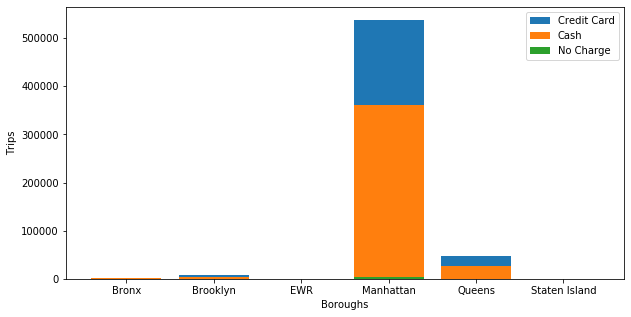

In [114]:
result = taxiSample.groupby(['payment_type','PULocationID'])['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','payment_type'])['count'].sum().reset_index(name='count')
print(groupResult)
payment1 = groupResult[groupResult.payment_type==1]['count']
payment2 = groupResult[groupResult.payment_type==2]['count']
payment3 = groupResult[groupResult.payment_type==3]['count']
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(groupResult['borough'].unique(), payment1, label = "Credit Card")
ax.bar(groupResult['borough'].unique(), payment2, label = "Cash")
ax.bar(groupResult['borough'].unique(), payment3, label = "No Charge")
ax.set_ylabel("Trips")
ax.set_xlabel("Boroughs")
ax.legend()

* We can see that EWR and Shaten Island has no Dispute payment type

## Fare and Tip amount

### What is the rate of tip?

In [55]:
no_tip = taxiSample[taxiSample.tip_amount==0]
no_tip.shape

(429807, 28)

In [56]:
tip = taxiSample[taxiSample.tip_amount>0]
tip.shape

(563028, 28)

In [57]:
(tip.shape[0]*100) / (no_tip.shape[0] + tip.shape[0])  # percentage of passenger that tips

56.709120850896674

### What is the relation between fareAmount and tip?

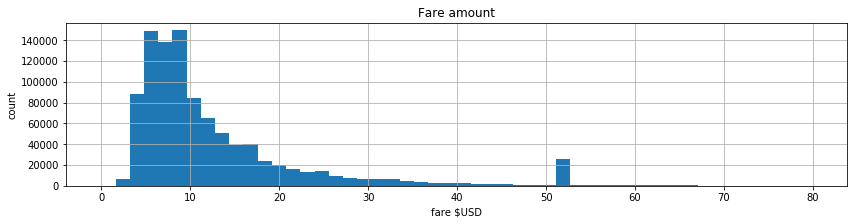

In [58]:
taxiSample[taxiSample.fare_amount<80].fare_amount.hist(bins=50, figsize=(14,3))
plt.xlabel('fare $USD')
plt.ylabel('count')
plt.title('Fare amount');

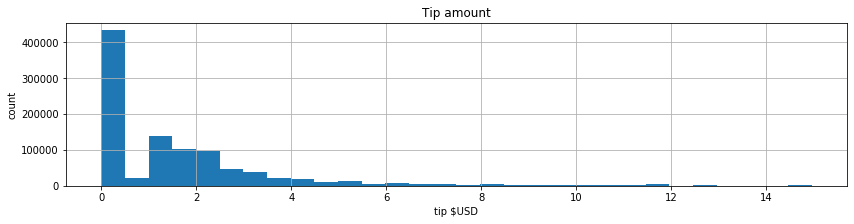

In [59]:
taxiSample[taxiSample.tip_amount<15].tip_amount.hist(bins=30, figsize=(14,3))
plt.xlabel('tip $USD')
plt.ylabel('count')
plt.title('Tip amount');

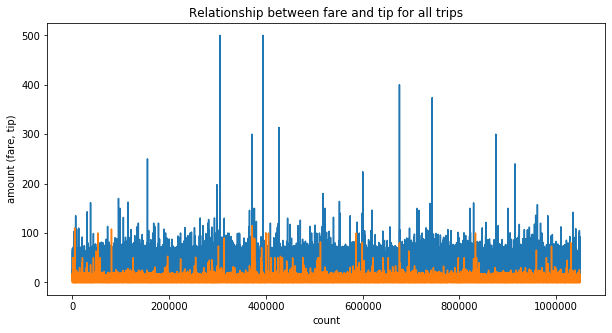

In [60]:
fare_tip = taxiSample[['fare_amount','tip_amount']]
plt.figure(figsize=(10,5))
plt.plot(fare_tip)
plt.title('Relationship between fare and tip for all trips')
plt.xlabel('count')
plt.ylabel('amount (fare, tip)')
plt.show()

## Tolls amount

### Which region has the most trips that includes a bridge? i.e. toll~bridge

{'EWR': 6, 'Queens': 32403, 'Bronx': 414, 'Manhattan': 18471, 'Staten Island': 16, 'Brooklyn': 594}


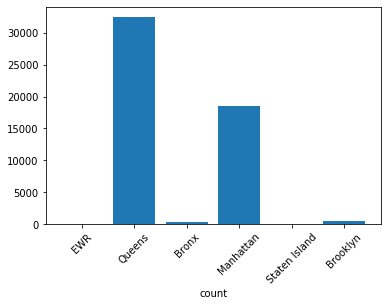

In [61]:
tollsCount = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    tollsCount[borough] = totalRideBorough[totalRideBorough.tolls_amount>0]['tolls_amount'].count()
print(tollsCount)
plt.bar(range(len(tollsCount)), list(tollsCount.values()), align='center')
plt.xticks(range(len(tollsCount)), list(tollsCount.keys()), rotation=45)
plt.xlabel('count')
plt.show()

## Pickup and Dropoff time

### Which day of the week has most pickup/dropoff?

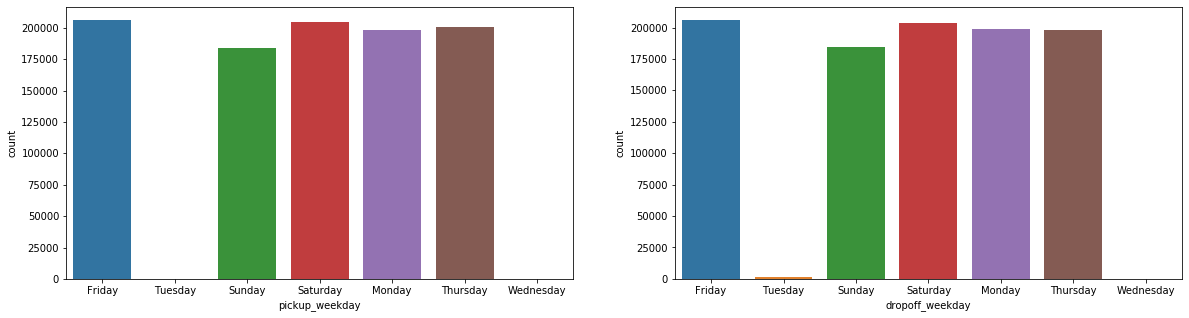

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_weekday", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_weekday", data=taxiSample, ax=ax[1])
plt.show()

### Which time of the day has most pickup/dropoff?

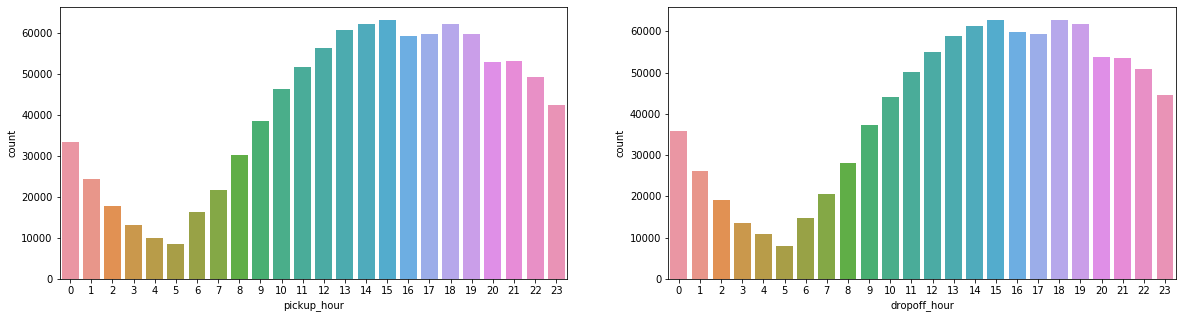

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_hour", data=taxiSample, ax=ax[1])
plt.show()

### Which month has the most pickup/dropoff?

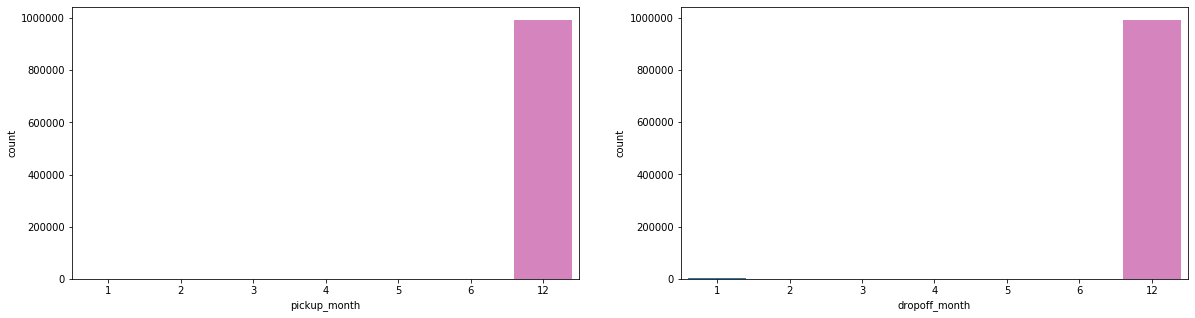

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_month", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_month", data=taxiSample, ax=ax[1])
plt.show()

### What is the busiest hour in each borough of New York City?

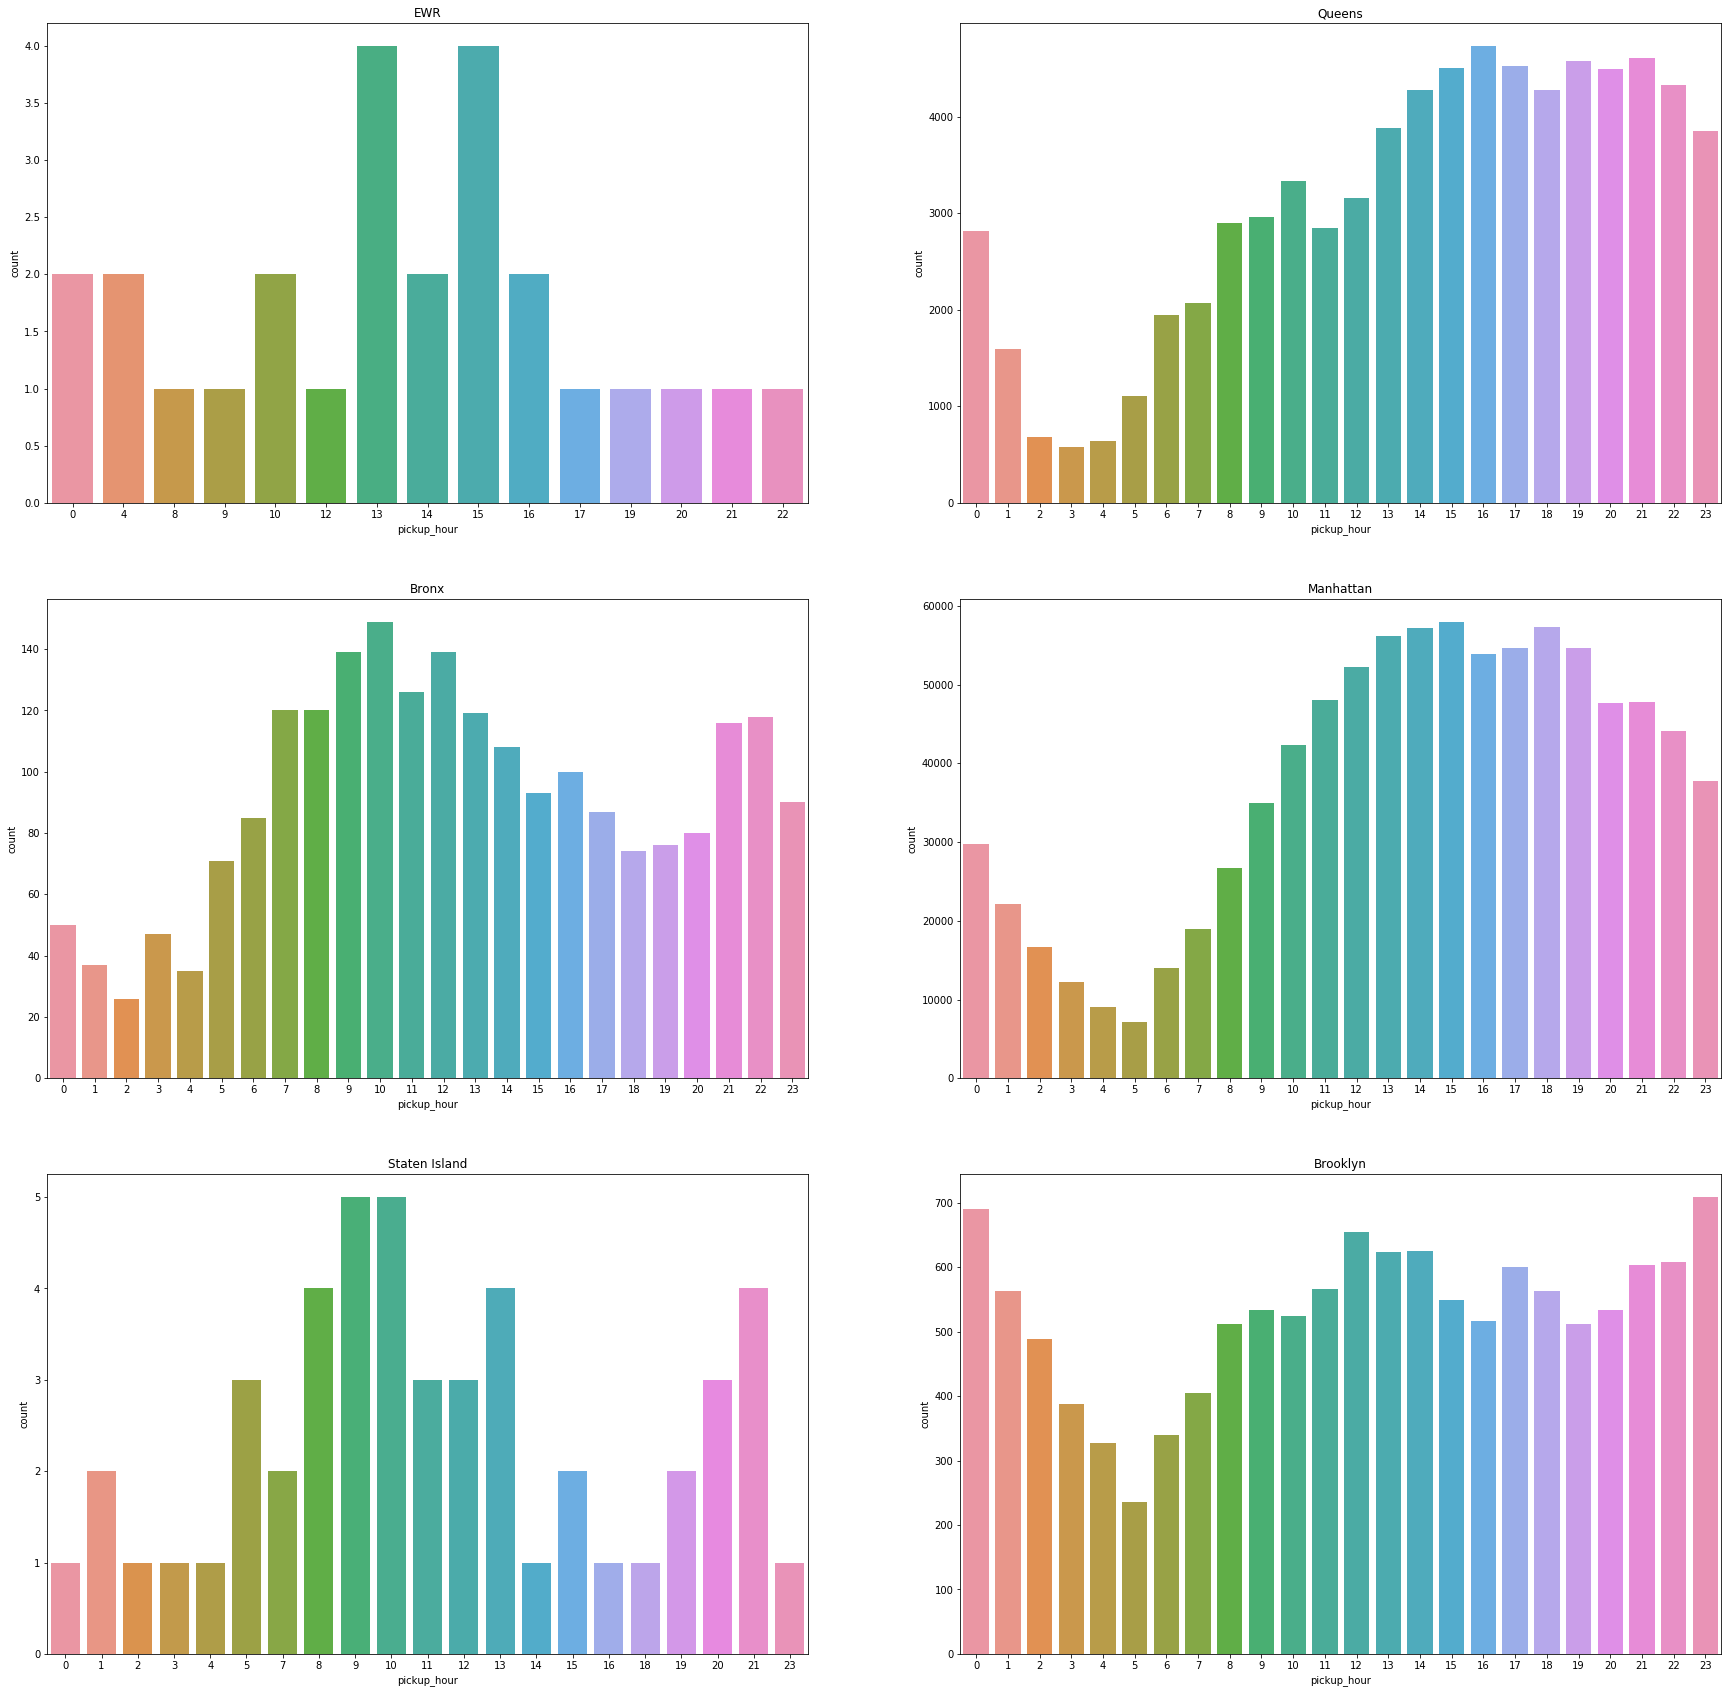

In [65]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_hour', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### What is the busiest day of a week in each borough of New York City?

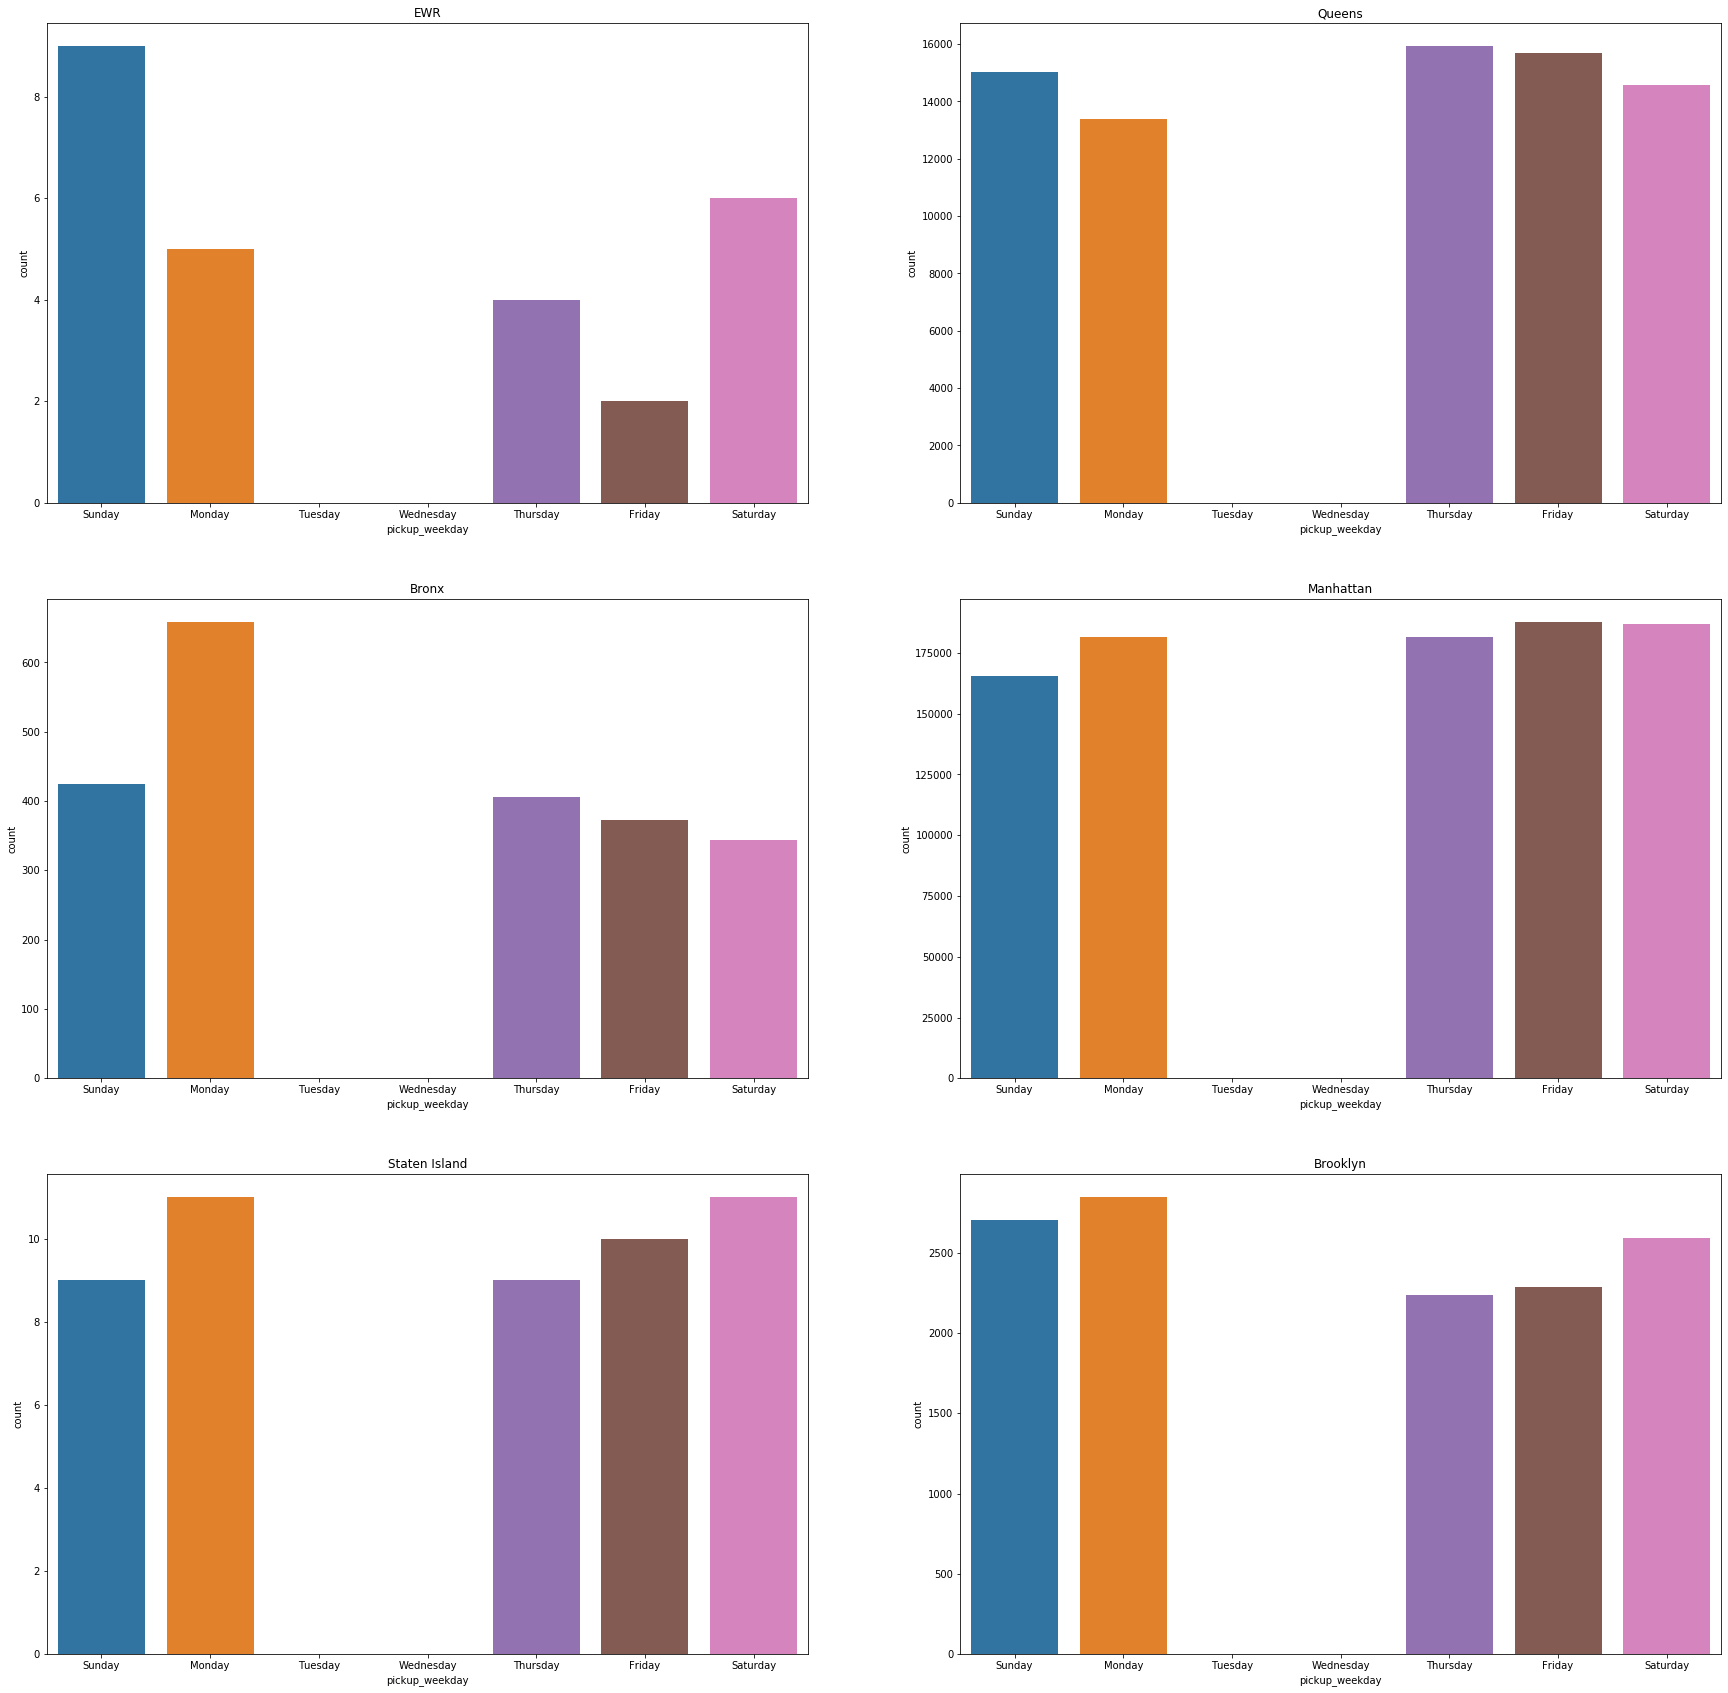

In [66]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_weekday', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### Which day is busiest in december in each region?

#### Based on pickup location id

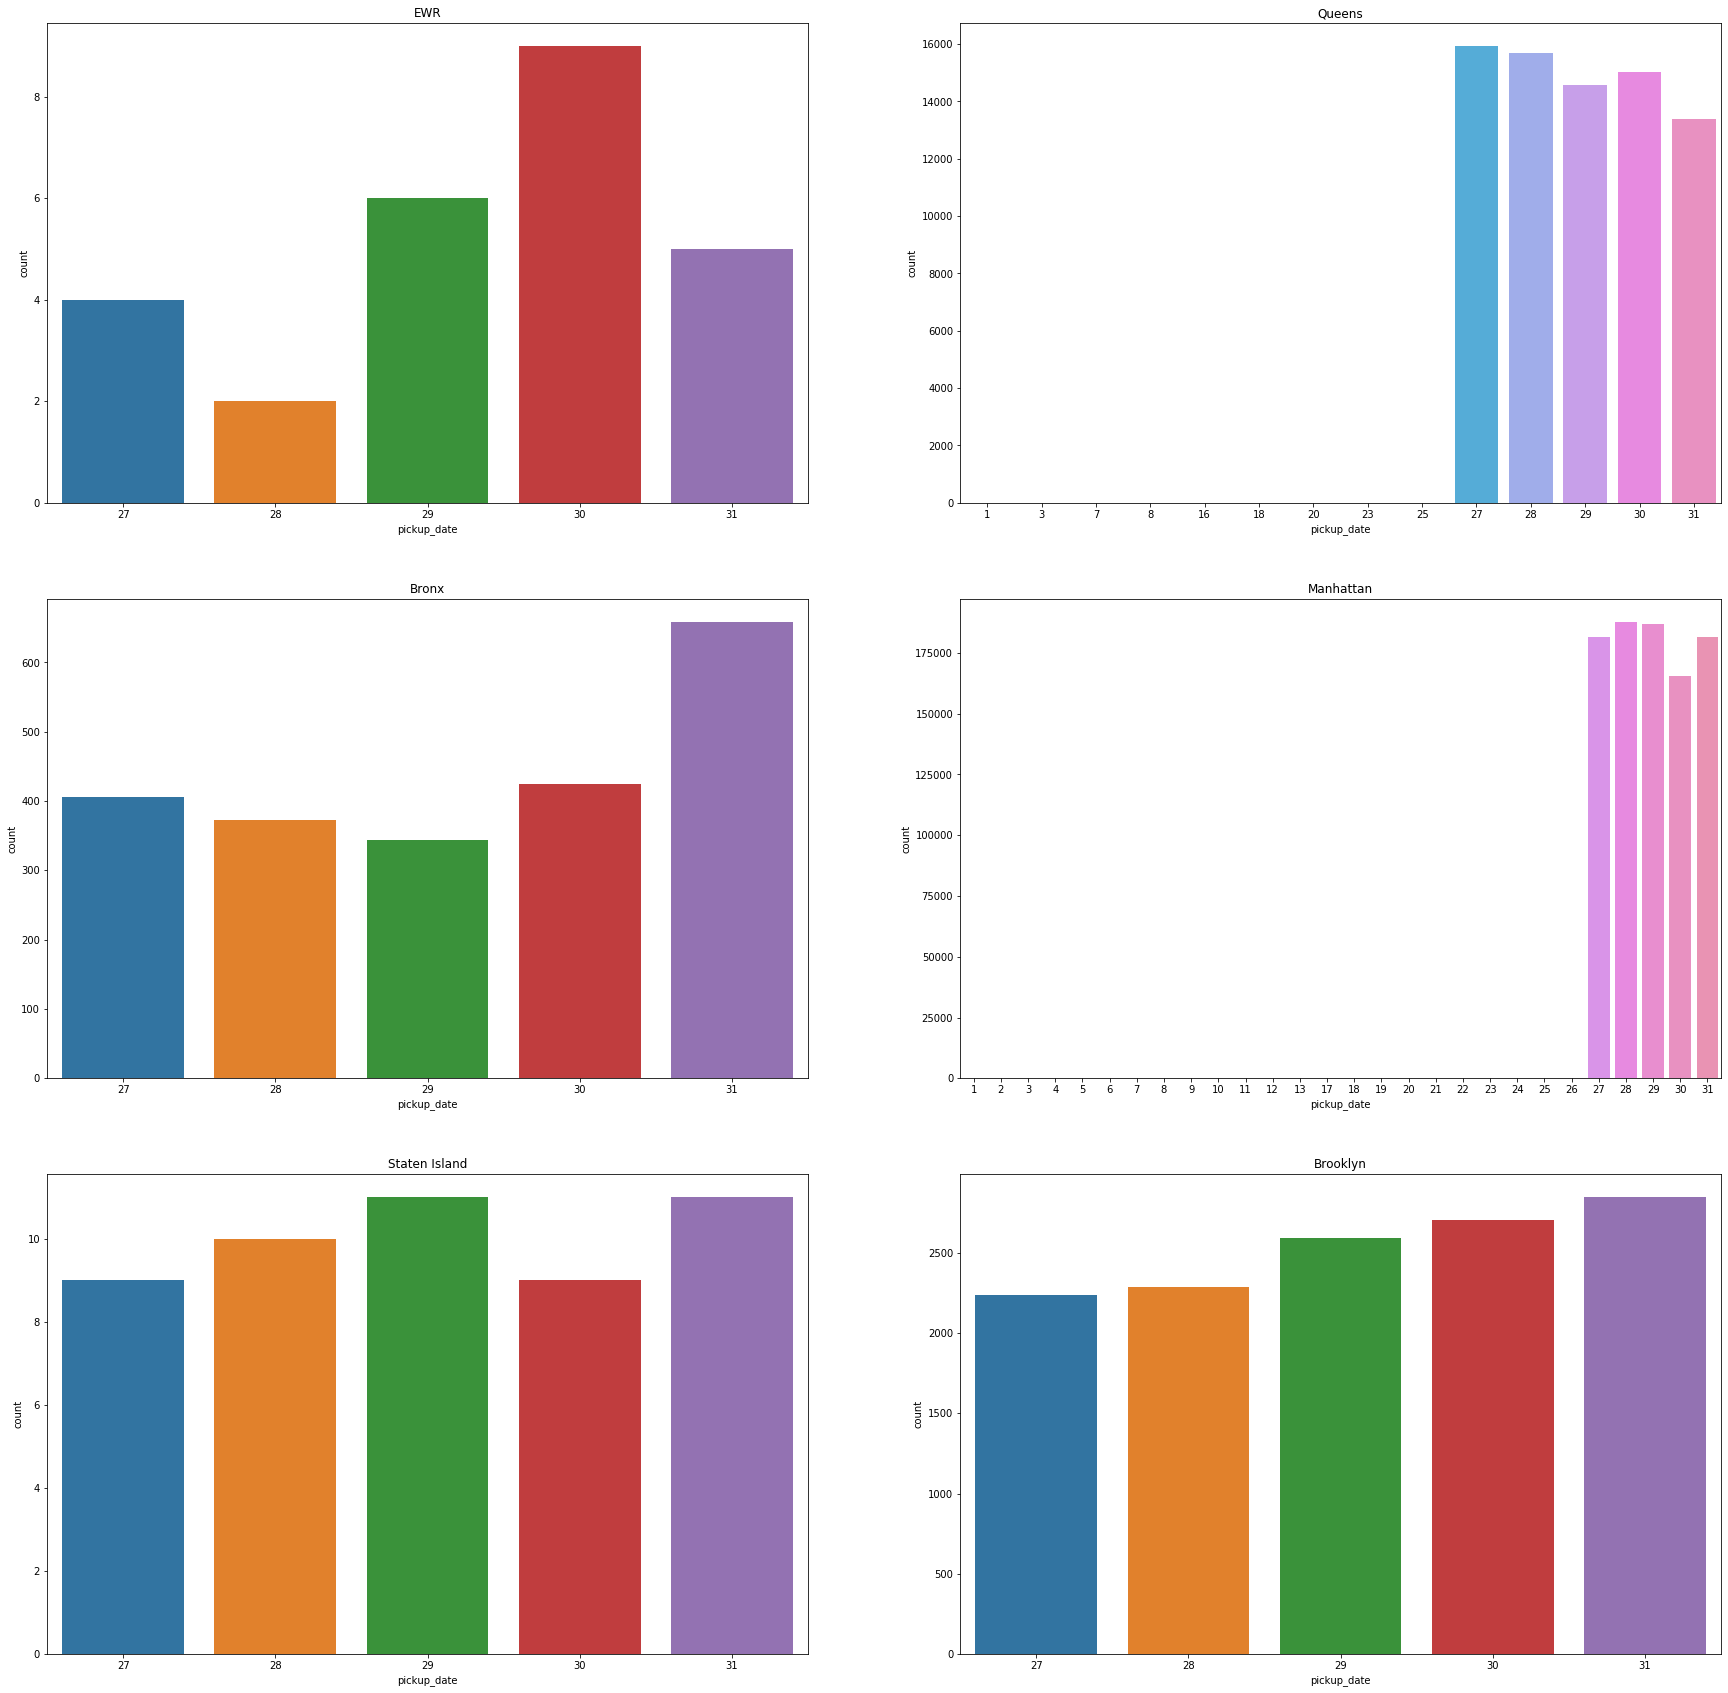

In [67]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='pickup_date', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

#### Based on dropoff location id

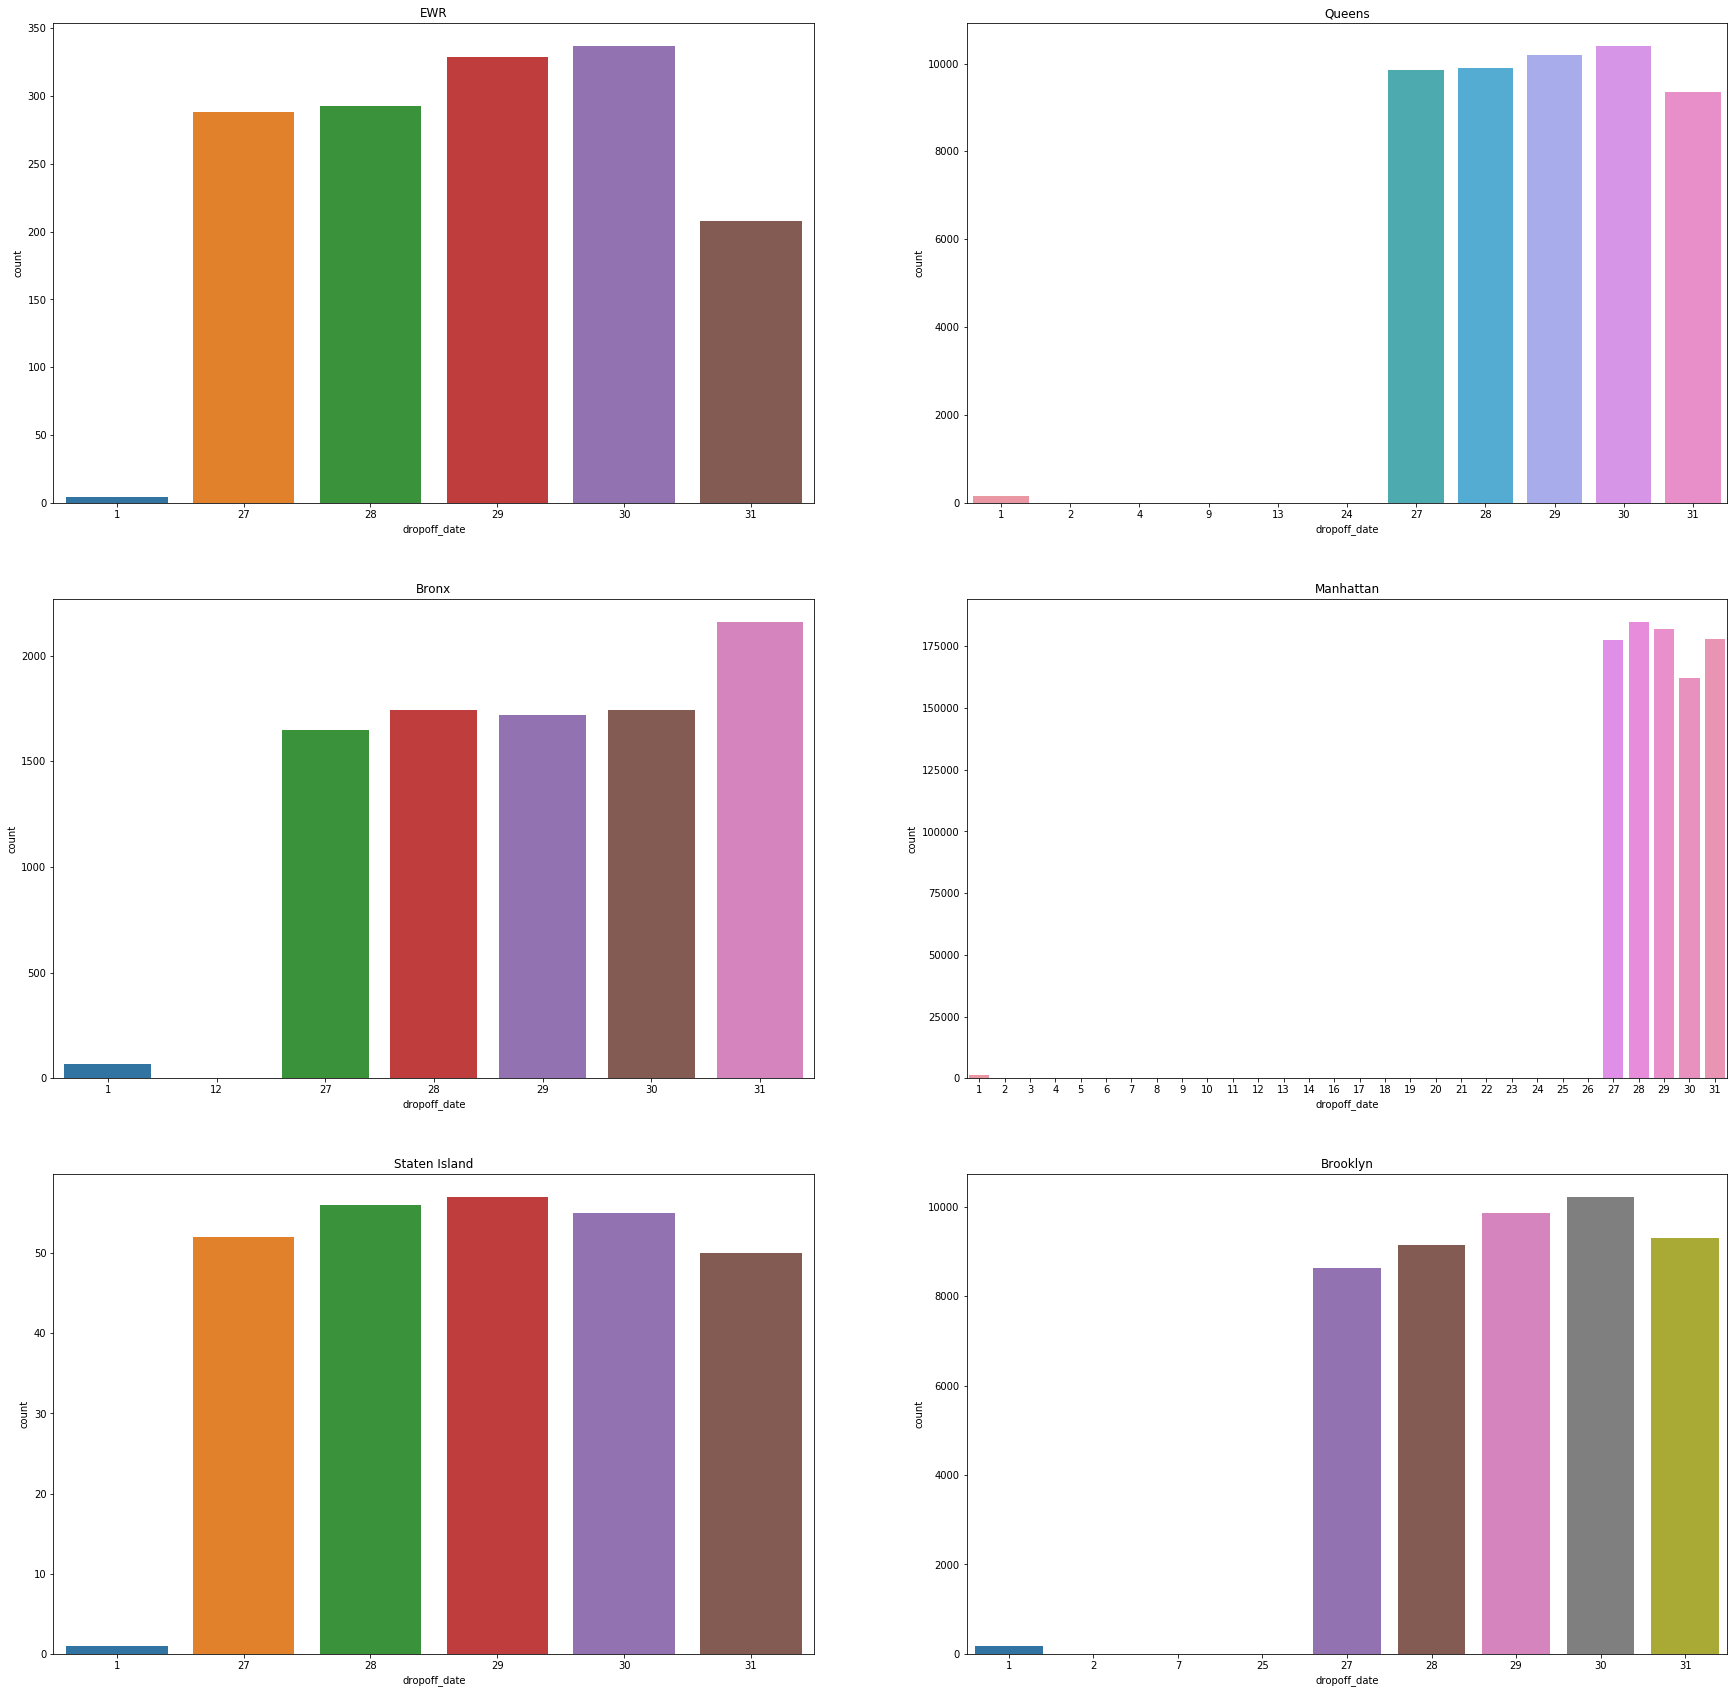

In [68]:
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'DOLocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='DOLocationID', how='inner')
    ax = fig.add_subplot(3, 2, index)
    sns.countplot(x='dropoff_date', data=totalRideBorough, ax=ax).set_title(borough)
    index += 1

### Show the number of trip vs day vs hour graph, so that we can easily know which time of a day is the busiest hour

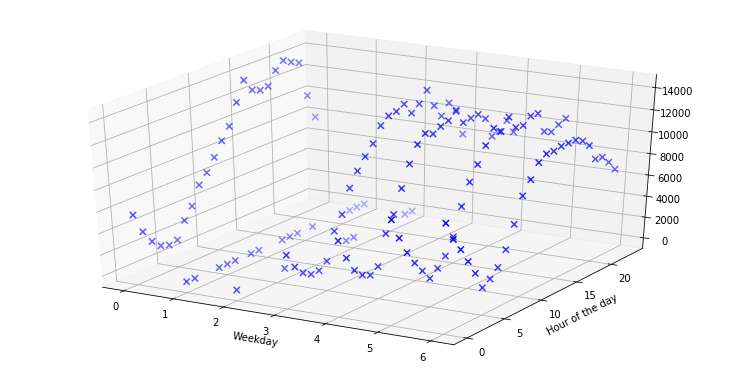

In [69]:
result = taxiSample.groupby(['pickup_dayofweek','pickup_hour'])['PULocationID'].count().reset_index(name='count')
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
x = result['pickup_dayofweek']
y = result['pickup_hour']
z = result['count']
ax.scatter(x, y, z, s=40, c='blue', marker='x')
plt.xlabel("Weekday")
plt.ylabel("Hour of the day")
plt.show()

## Trip duration

In [70]:
taxiSample['trip_duration'] = (taxiSample.tpep_dropoff_datetime - taxiSample.tpep_pickup_datetime).dt.total_seconds()

In [71]:
taxiSample.trip_duration.describe()

count    992835.000000
mean       1115.597201
std        5001.819985
min           1.000000
25%         372.000000
50%         642.000000
75%        1082.000000
max       86394.000000
Name: trip_duration, dtype: float64

### Which day has the most trip duration?

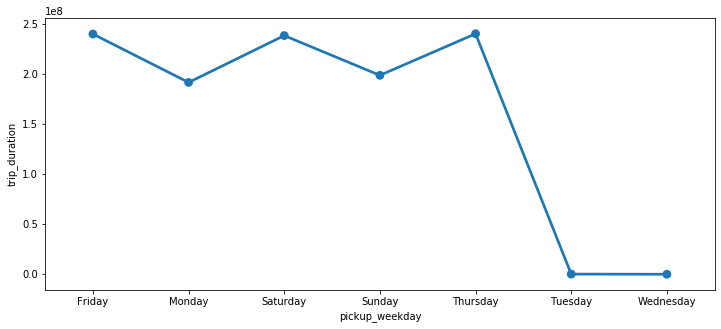

In [72]:
df_train_agg = taxiSample.groupby('pickup_weekday')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_weekday, df_train_agg.trip_duration)
plt.show()

### Which time has the most trip duration?

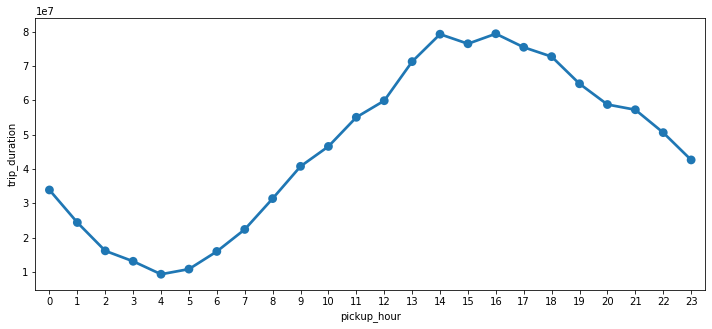

In [73]:
df_train_agg = taxiSample.groupby('pickup_hour')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_hour, df_train_agg.trip_duration)
plt.show()

## Trip distance

In [74]:
taxiSample['trip_distance'].describe()

count    992835.000000
mean          3.038173
std           3.893990
min           0.010000
25%           0.975000
50%           1.640000
75%           3.130000
max          91.170000
Name: trip_distance, dtype: float64

### What is the number of short and long distance trip? (i.e. short distance<20)

In [75]:
short_distance = taxiSample[taxiSample.trip_distance<20.0]
long_distance = taxiSample[taxiSample.trip_distance>=20.0]
print(short_distance.shape)
print(long_distance.shape)

(985257, 29)
(7578, 29)


### Which time of the day has the most short distance trip?

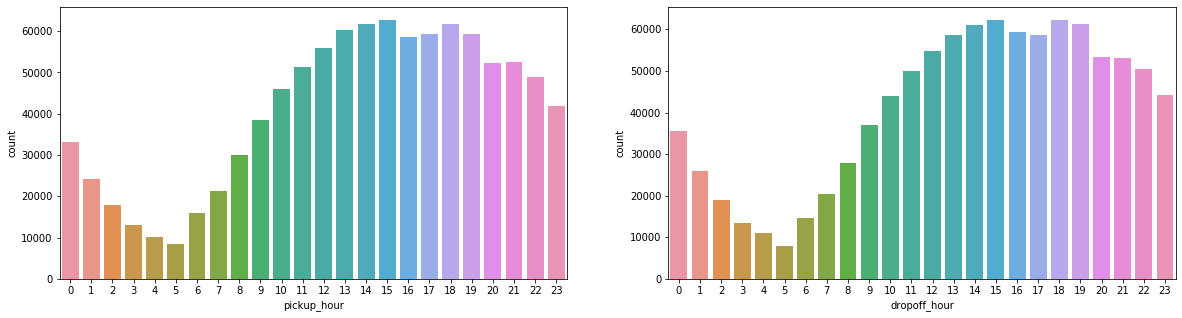

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=short_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=short_distance, ax=ax[1])
plt.show()

### Which time of the day has the most long distance trip?

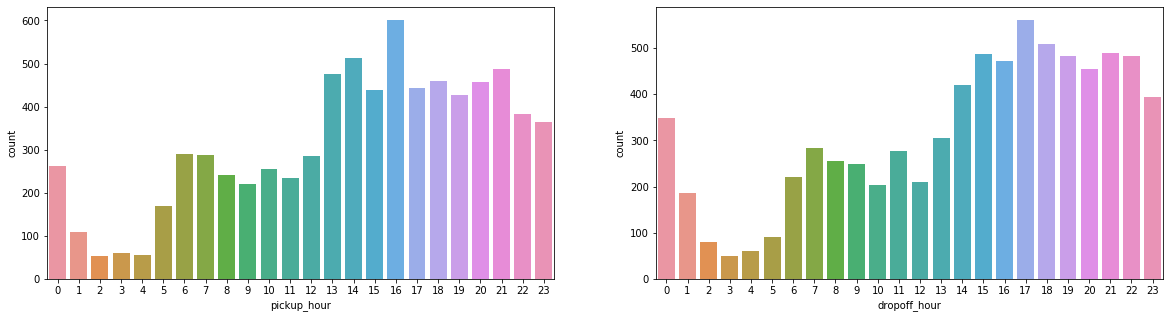

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=long_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=long_distance, ax=ax[1])
plt.show()

## Traffic condition

### What is the average trip distance of the day?

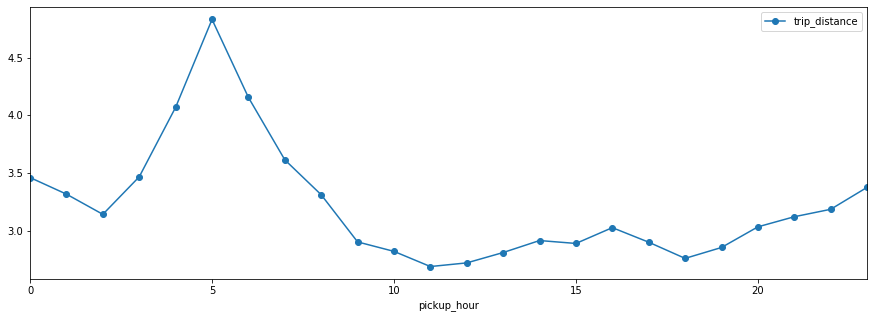

In [78]:
traffic = taxiSample.groupby('pickup_hour')['trip_distance','trip_duration'].mean().reset_index()
ax = traffic.plot(x='pickup_hour', y='trip_distance', kind='line', style="-o", figsize=(15,5))
plt.show()

### What is the average trip duration of the day?

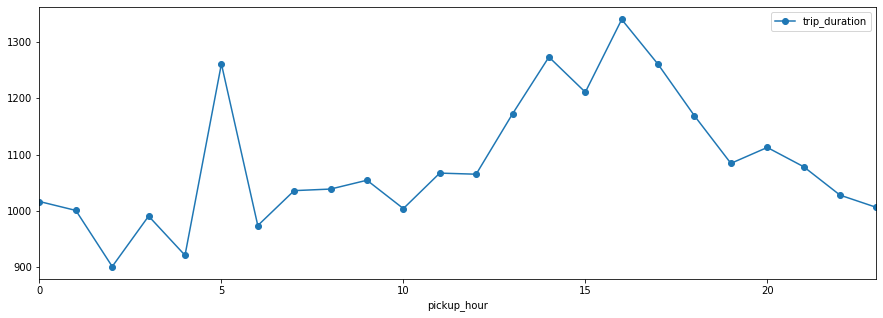

In [79]:
ax = traffic.plot(x='pickup_hour', y=['trip_duration'], kind='line', style="-o", figsize=(15,5))
plt.show()

### What is the traffic condition(trip duration/trip distance) of different regions during a day?

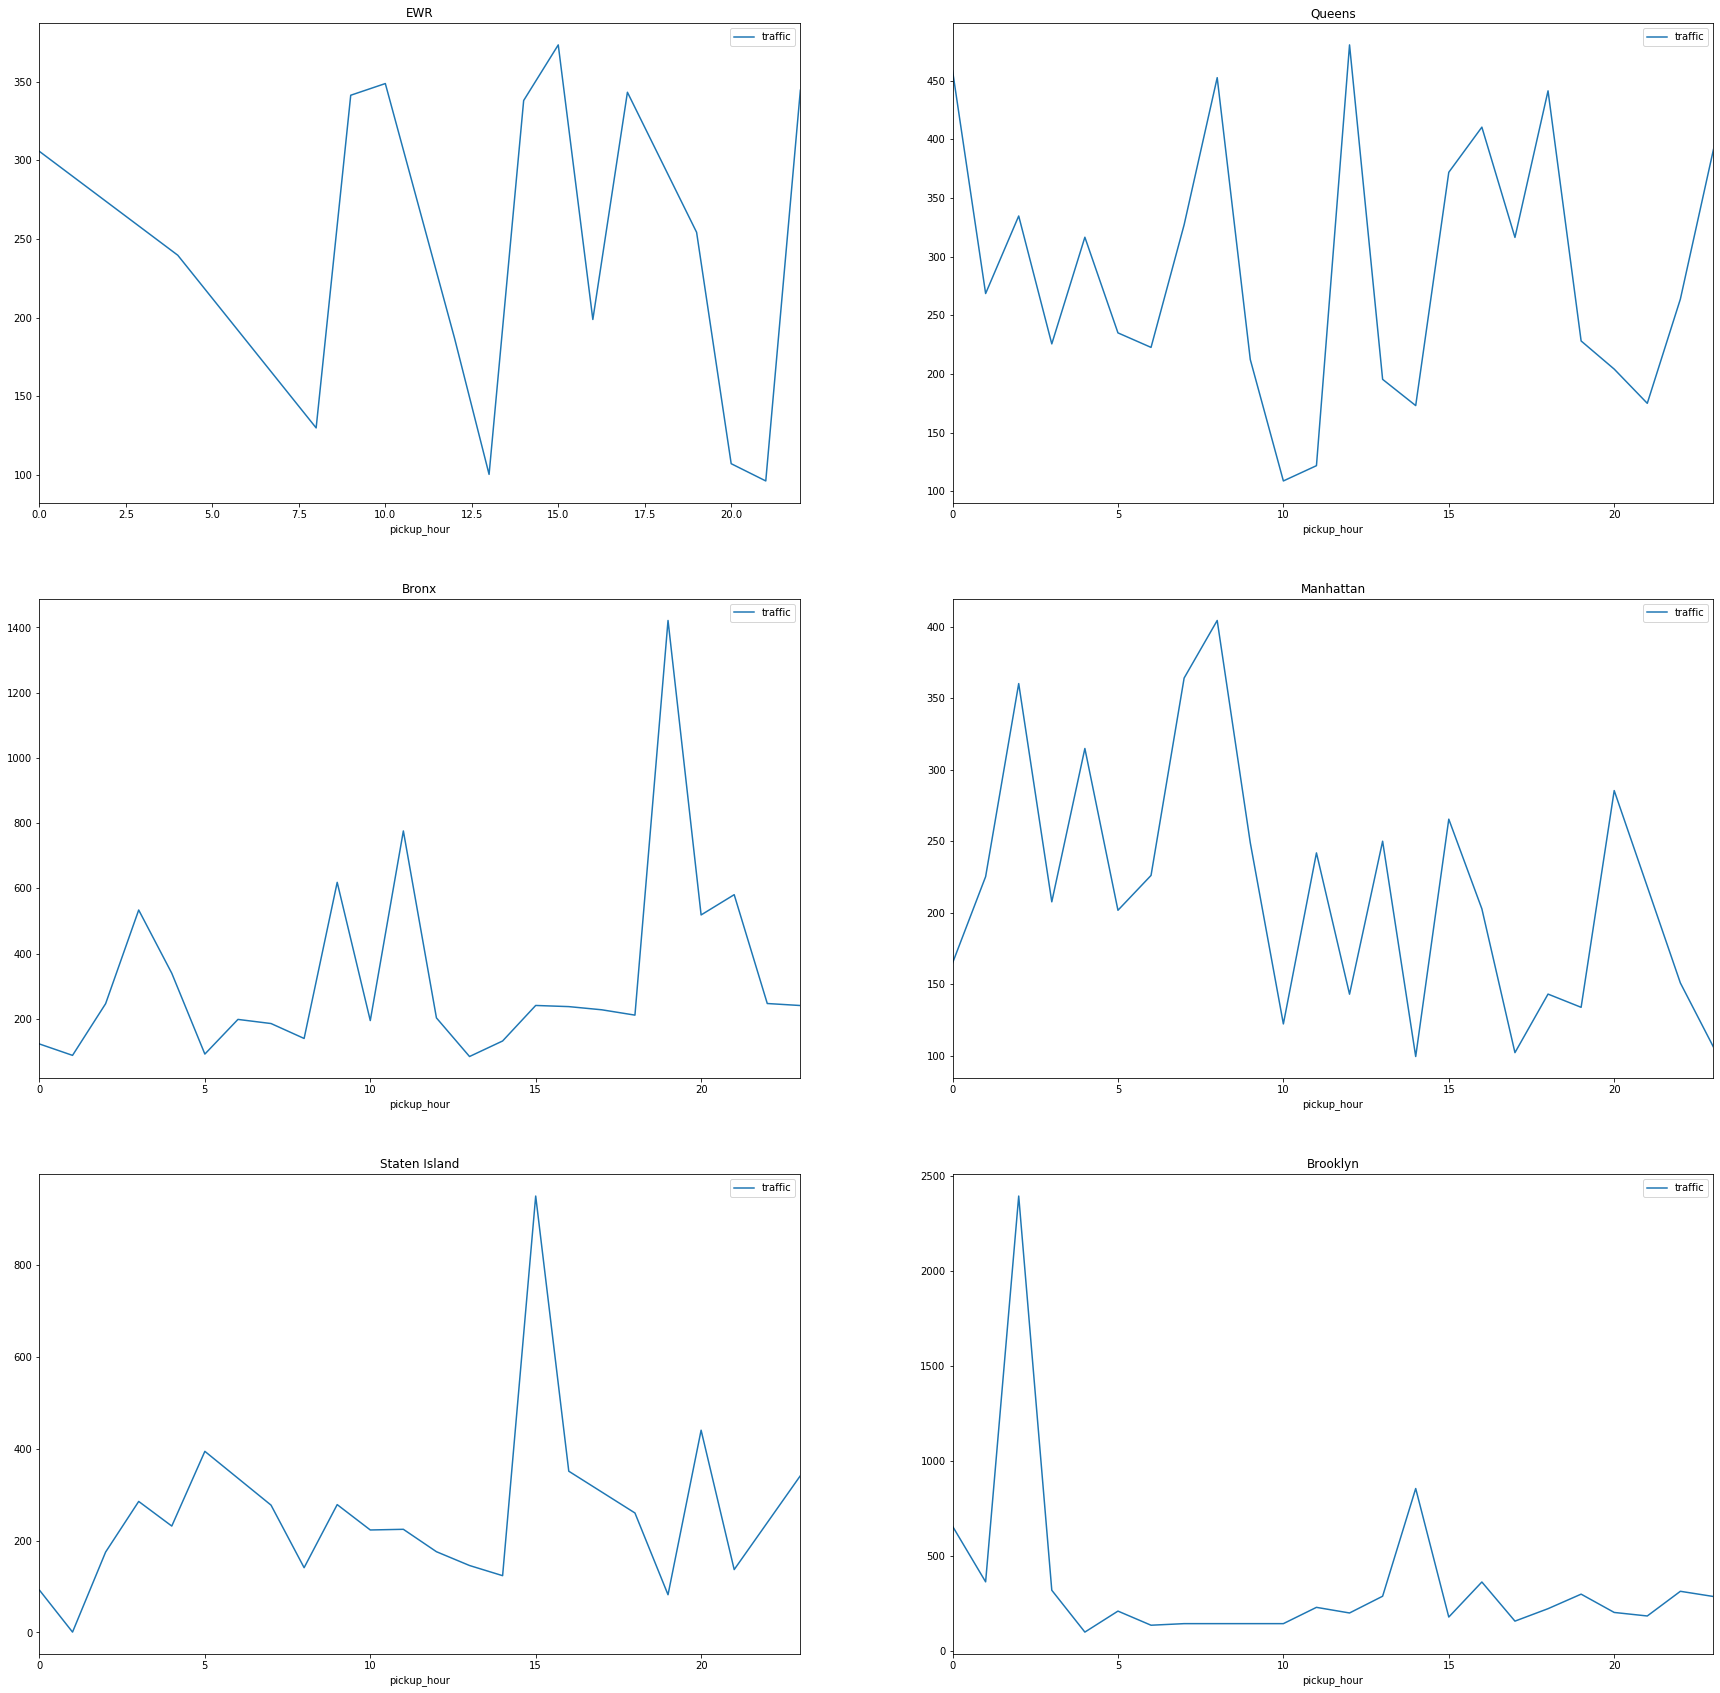

In [80]:
result = taxiSample.groupby(['pickup_hour','PULocationID'])['trip_distance','trip_duration'].sum().reset_index().rename(columns={'PULocationID':'LocationID'})
result = result.merge(taxiZone, on='LocationID', how='left')
groupResult = result.groupby(['borough','pickup_hour'])['trip_distance','trip_duration'].sum().reset_index()
groupResult['traffic'] = result['trip_duration']/result['trip_distance']
fig = plt.figure(figsize=(30,30))
index = 1
for borough in boroughs:
    ax = fig.add_subplot(3, 2, index)
    boroughData = groupResult[groupResult.borough==borough]
    boroughData.plot(x='pickup_hour', y='traffic', ax=ax).set_title(borough)
    index += 1

## Pickup/Dropoff location id

In [81]:
pu_location = taxiSample.groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location = taxiSample.groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

### Show the top 5 zones with most pickups and dropoffs

In [82]:
pu_do_location = taxiZone.merge(pu_location, on='LocationID', how='left')
pu_do_location = pu_do_location.merge(do_location, on='LocationID', how='left')
pu_do_location['totalCount'] = pu_do_location['puCount'] + pu_do_location['doCount']
pu_do_location.head()

LocationID  OBJECTID  Shape_Area  Shape_Leng        borough  \
0           1         1    0.000782    0.116357            EWR   
1           2         2    0.004866    0.433470         Queens   
2           3         3    0.000314    0.084341          Bronx   
3           4         4    0.000112    0.043567      Manhattan   
4           5         5    0.000498    0.092146  Staten Island   

                      zone     longitude       latitude  puCount  doCount  \
0           Newark Airport  9.366817e+05  190522.130278     26.0   1459.0   
1              Jamaica Bay  1.033536e+06  161853.982300      1.0      1.0   
2  Allerton/Pelham Gardens  1.027136e+06  254730.010849     27.0     89.0   
3            Alphabet City  9.904240e+05  203100.040432   2202.0   5371.0   
4            Arden Heights  9.321332e+05  139954.541936      1.0      7.0   

   totalCount  
0      1485.0  
1         2.0  
2       116.0  
3      7573.0  
4         8.0

In [83]:
puCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['puCount'].tolist()))
puTop5 = pu_do_location.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['doCount'].tolist()))
doTop5 = pu_do_location.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 pickup zone

In [84]:
puTop5

OBJECTID  Shape_Area  Shape_Leng    borough  \
LocationID                                                
186              186    0.000037    0.024696  Manhattan   
48                48    0.000094    0.043747  Manhattan   
237              237    0.000096    0.042213  Manhattan   
161              161    0.000072    0.035804  Manhattan   
162              162    0.000048    0.035270  Manhattan   

                                    zone      longitude       latitude  \
LocationID                                                               
186         Penn Station/Madison Sq West  986346.343415  211974.157667   
48                          Clinton East  987065.467994  216984.693458   
237                Upper East Side South  993768.783313  219305.448647   
161                       Midtown Center  990433.407940  215448.355221   
162                         Midtown East  991876.747966  215015.150630   

            puCount  doCount  totalCount  
LocationID                                
186         41710.0  27609.0     69319.0  
48          37723.0  33649.0     71372.0  
237         36194.0  32237.0     68431.0  
161         35750.0  36476.0     72226.0  
162         32759.0  28612.0     61371.0

#### Top 5 dropoff zone

In [85]:
doTop5

OBJECTID  Shape_Area  Shape_Leng    borough  \
LocationID                                                
161              161    0.000072    0.035804  Manhattan   
48                48    0.000094    0.043747  Manhattan   
236              236    0.000103    0.044252  Manhattan   
237              237    0.000096    0.042213  Manhattan   
230              230    0.000056    0.031028  Manhattan   

                                 zone      longitude       latitude  puCount  \
LocationID                                                                     
161                    Midtown Center  990433.407940  215448.355221  35750.0   
48                       Clinton East  987065.467994  216984.693458  37723.0   
236             Upper East Side North  996155.897922  223614.973989  32098.0   
237             Upper East Side South  993768.783313  219305.448647  36194.0   
230         Times Sq/Theatre District  988628.078498  216098.909900  30608.0   

            doCount  totalCount  
LocationID                       
161         36476.0     72226.0  
48          33649.0     71372.0  
236         33434.0     65532.0  
237         32237.0     68431.0  
230         29639.0     60247.0

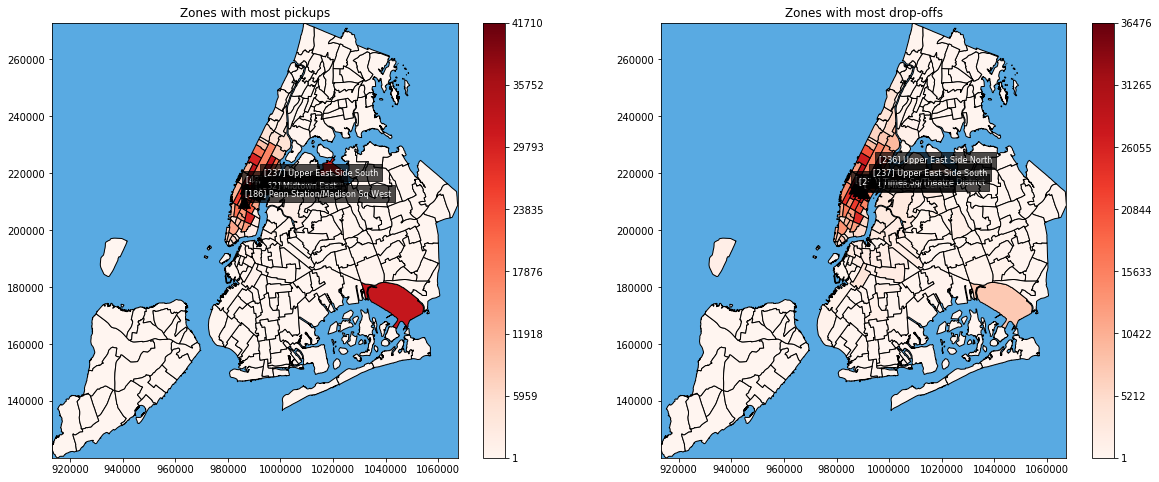

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, taxiZonesShape, heat=puCount, text=puTop5.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, taxiZonesShape, heat=doCount, text=doTop5.index.tolist())

### Which region has the most pickups and dropoffs?

In [87]:
pu_do_region = pu_do_location.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region

borough   puCount   doCount  totalCount
3      Manhattan  903507.0  885921.0   1789428.0
4         Queens   74637.0   49856.0    124476.0
1       Brooklyn   12675.0   47336.0     60011.0
0          Bronx    2205.0    9081.0     11259.0
2            EWR      26.0    1459.0      1485.0
5  Staten Island      50.0     271.0       287.0

In [88]:
puCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['puCount'].tolist()))
doCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['doCount'].tolist()))

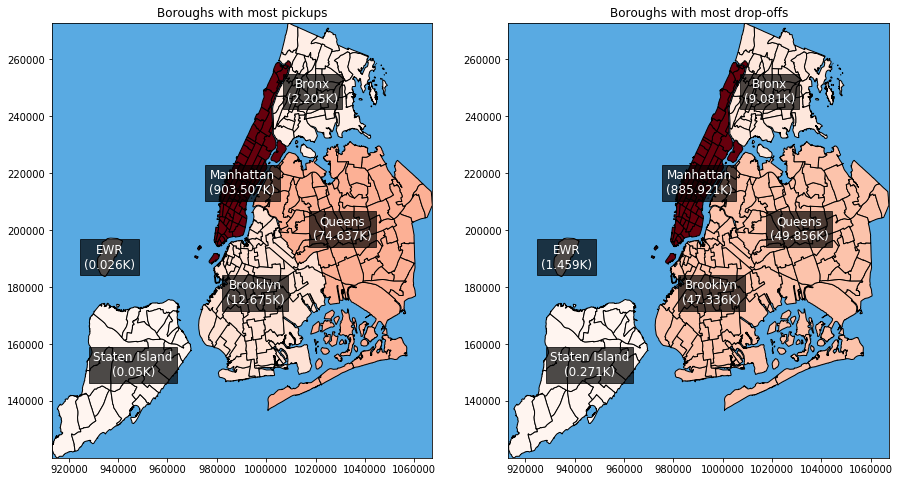

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, taxiZonesShape, heat = puCount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, taxiZonesShape, heat = doCount)

### Which zone has the most pickups/dropoffs for short trips (distance<20) and long trips (distance>=20)

In [90]:
pu_location_short = taxiSample[taxiSample.trip_distance<20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_short = taxiSample[taxiSample.trip_distance<20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_short = taxiZone.merge(pu_location_short, on='LocationID', how='left')
pu_do_location_short = pu_do_location_short.merge(do_location_short, on='LocationID', how='left')
pu_do_location_short['totalCount'] = pu_do_location_short['puCount'] + pu_do_location_short['doCount']

In [91]:
pu_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_long = taxiZone.merge(pu_location_long, on='LocationID', how='left')
pu_do_location_long = pu_do_location_long.merge(do_location_long, on='LocationID', how='left')
pu_do_location_long['totalCount'] = pu_do_location_long['puCount'] + pu_do_location_long['doCount']

In [92]:
puCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['puCount'].tolist()))
puTop5Short = pu_do_location_short.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['doCount'].tolist()))
doTop5Short = pu_do_location_short.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 short distance pickup zone

In [93]:
puTop5Short

OBJECTID  Shape_Area  Shape_Leng    borough  \
LocationID                                                
186              186    0.000037    0.024696  Manhattan   
48                48    0.000094    0.043747  Manhattan   
237              237    0.000096    0.042213  Manhattan   
161              161    0.000072    0.035804  Manhattan   
162              162    0.000048    0.035270  Manhattan   

                                    zone      longitude       latitude  \
LocationID                                                               
186         Penn Station/Madison Sq West  986346.343415  211974.157667   
48                          Clinton East  987065.467994  216984.693458   
237                Upper East Side South  993768.783313  219305.448647   
161                       Midtown Center  990433.407940  215448.355221   
162                         Midtown East  991876.747966  215015.150630   

            puCount  doCount  totalCount  
LocationID                                
186         41684.0  27595.0     69279.0  
48          37635.0  33559.0     71194.0  
237         36159.0  32146.0     68305.0  
161         35697.0  36438.0     72135.0  
162         32724.0  28561.0     61285.0

#### Top 5 short distance dropoff zone

In [94]:
doTop5Short

OBJECTID  Shape_Area  Shape_Leng    borough  \
LocationID                                                
161              161    0.000072    0.035804  Manhattan   
48                48    0.000094    0.043747  Manhattan   
236              236    0.000103    0.044252  Manhattan   
237              237    0.000096    0.042213  Manhattan   
170              170    0.000074    0.045769  Manhattan   

                             zone      longitude       latitude  puCount  \
LocationID                                                                 
161                Midtown Center  990433.407940  215448.355221  35697.0   
48                   Clinton East  987065.467994  216984.693458  37635.0   
236         Upper East Side North  996155.897922  223614.973989  32059.0   
237         Upper East Side South  993768.783313  219305.448647  36159.0   
170                   Murray Hill  990443.335463  211693.748324  29730.0   

            doCount  totalCount  
LocationID                       
161         36438.0     72135.0  
48          33559.0     71194.0  
236         33388.0     65447.0  
237         32146.0     68305.0  
170         29617.0     59347.0

In [95]:
puCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['puCount'].tolist()))
puTop5Long = pu_do_location_long.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['doCount'].tolist()))
doTop5Long = pu_do_location_long.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

#### Top 5 long distance pickup zone

In [96]:
puTop5Long

OBJECTID  Shape_Area  Shape_Leng    borough  \
LocationID                                                
132              132    0.002038    0.245479     Queens   
239              239    0.000205    0.063626  Manhattan   
142              142    0.000076    0.038176  Manhattan   
138              138    0.000537    0.107467     Queens   
13                13    0.000149    0.050281  Manhattan   

                             zone     longitude       latitude  puCount  \
LocationID                                                                
132                   JFK Airport  1.042628e+06  173494.353508   5396.0   
239         Upper West Side South  9.901399e+05  224918.916683    140.0   
142           Lincoln Square East  9.893656e+05  221142.058374    104.0   
138             LaGuardia Airport  1.019304e+06  221604.395797     97.0   
13              Battery Park City  9.798442e+05  198508.159318     89.0   

            doCount  totalCount  
LocationID                       
132           874.0      6270.0  
239           391.0       531.0  
142           251.0       355.0  
138            17.0       114.0  
13            201.0       290.0

#### Top 5 long distance dropoff zone

In [97]:
doTop5Long

OBJECTID  Shape_Area  Shape_Leng    borough  \
LocationID                                                
132              132    0.002038    0.245479     Queens   
239              239    0.000205    0.063626  Manhattan   
238              238    0.000185    0.060109  Manhattan   
1                  1    0.000782    0.116357        EWR   
87                87    0.000067    0.036902  Manhattan   

                                zone     longitude       latitude  puCount  \
LocationID                                                                   
132                      JFK Airport  1.042628e+06  173494.353508   5396.0   
239            Upper West Side South  9.901399e+05  224918.916683    140.0   
238            Upper West Side North  9.917176e+05  227746.100420     67.0   
1                     Newark Airport  9.366817e+05  190522.130278      2.0   
87          Financial District North  9.822430e+05  196731.423073     48.0   

            doCount  totalCount  
LocationID                       
132           874.0      6270.0  
239           391.0       531.0  
238           357.0       424.0  
1             282.0       284.0  
87            270.0       318.0

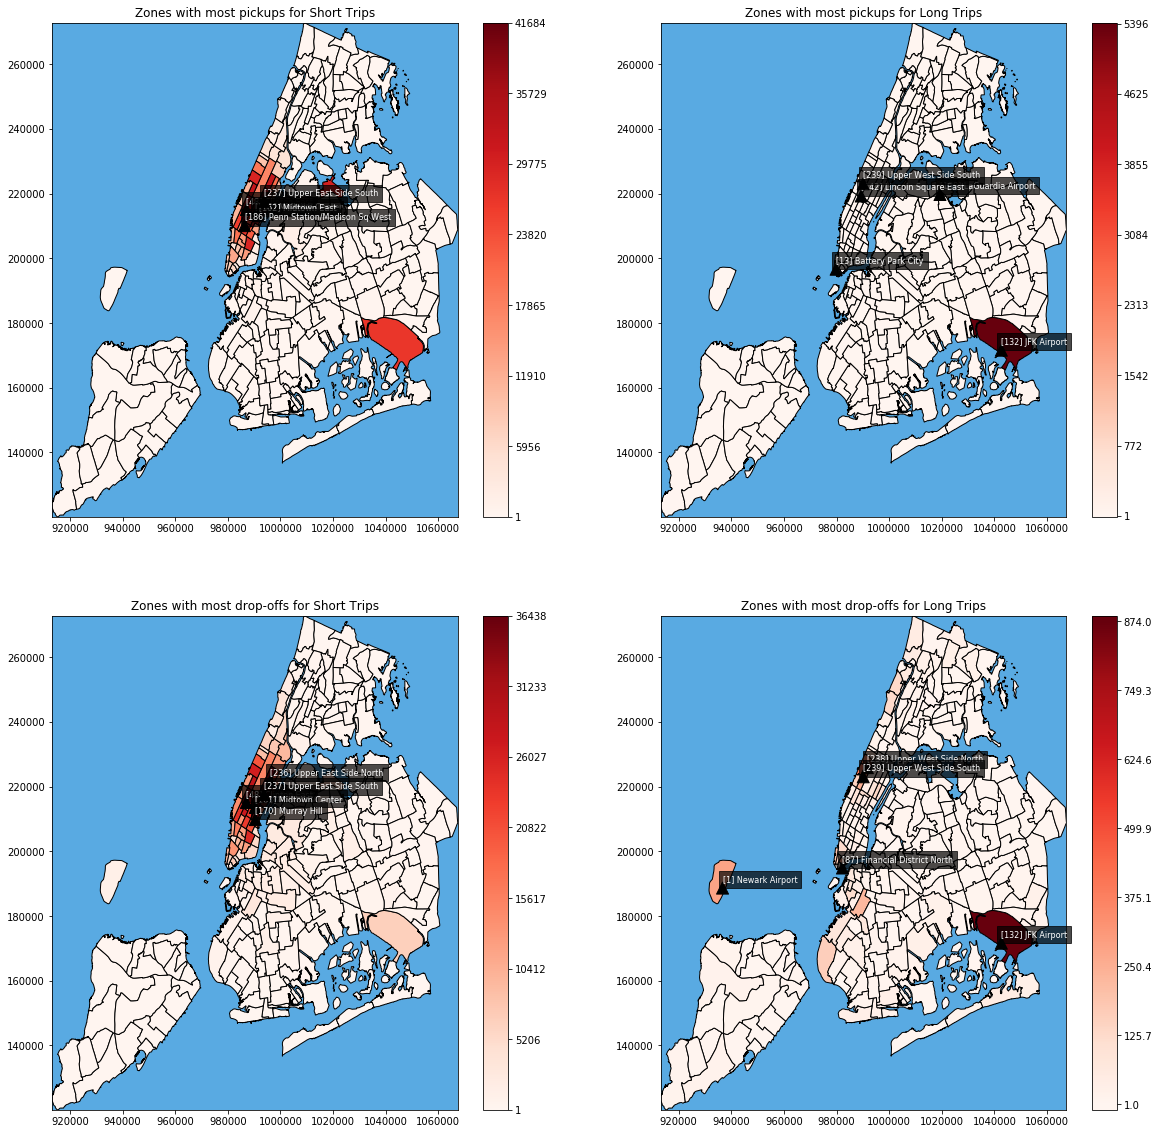

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=puCountShort, text=puTop5Short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, taxiZonesShape, heat=puCountLong, text=puTop5Long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=doCountShort, text=doTop5Short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, taxiZonesShape, heat=doCountLong, text=doTop5Long.index.tolist())

### Which region is popular for short trips and long trips?

#### Most popular region for short trips

In [99]:
pu_do_region_short = pu_do_location_short.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_short

borough   puCount   doCount  totalCount
3      Manhattan  901879.0  881957.0   1783836.0
4         Queens   68990.0   48652.0    117626.0
1       Brooklyn   12477.0   45830.0     58307.0
0          Bronx    2114.0    8601.0     10667.0
2            EWR      24.0    1177.0      1201.0
5  Staten Island      38.0     126.0       139.0

#### Most popular region for long trips

In [100]:
pu_do_region_long = pu_do_location_long.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_long

borough  puCount  doCount  totalCount
4         Queens   5647.0   1204.0      6819.0
3      Manhattan   1628.0   3964.0      5585.0
1       Brooklyn    198.0   1506.0      1584.0
0          Bronx     91.0    480.0       458.0
2            EWR      2.0    282.0       284.0
5  Staten Island     12.0    145.0        78.0

In [101]:
totalCountShort = dict(zip(pu_do_region_short['borough'].tolist(), pu_do_region_short['totalCount'].tolist()))
totalCountLong = dict(zip(pu_do_region_long['borough'].tolist(), pu_do_region_long['totalCount'].tolist()))

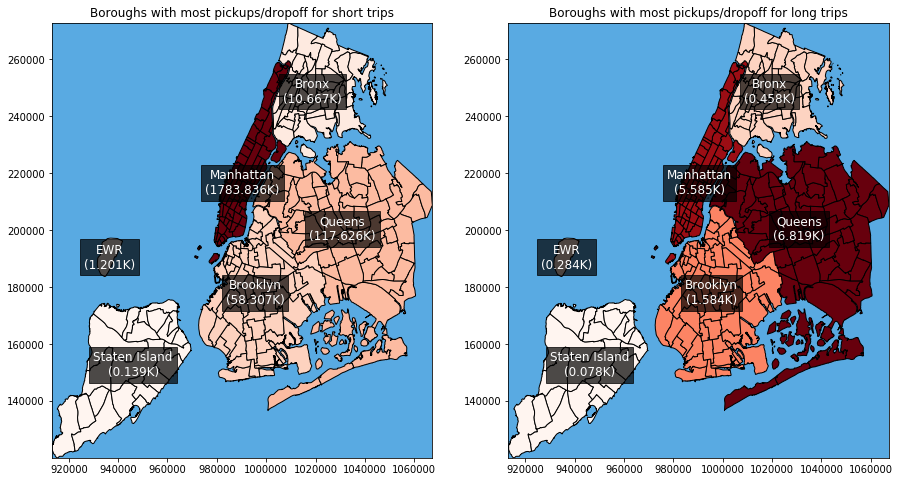

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups/dropoff for short trips")
draw_region_map(ax, taxiZonesShape, heat = totalCountShort)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most pickups/dropoff for long trips")
draw_region_map(ax, taxiZonesShape, heat = totalCountLong)

### Show top 5 inter zone trip

In [103]:
intraZone = taxiSample[taxiSample.PULocationID == taxiSample.DOLocationID].groupby('PULocationID')['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'}).sort_values(by='count', ascending=False).head(5)
intraZone = intraZone.merge(taxiZone, on='LocationID', how='left')
intraZone

LocationID  count  OBJECTID  Shape_Area  Shape_Leng    borough  \
0         237   4043       237    0.000096    0.042213  Manhattan   
1         236   3991       236    0.000103    0.044252  Manhattan   
2          48   2898        48    0.000094    0.043747  Manhattan   
3         239   2546       239    0.000205    0.063626  Manhattan   
4          79   2311        79    0.000108    0.042625  Manhattan   

                    zone      longitude       latitude  
0  Upper East Side South  993768.783313  219305.448647  
1  Upper East Side North  996155.897922  223614.973989  
2           Clinton East  987065.467994  216984.693458  
3  Upper West Side South  990139.871381  224918.916683  
4           East Village  988320.124716  204490.058251

In [104]:
countList = dict(zip(intraZone['LocationID'].tolist(), intraZone['count'].tolist()))

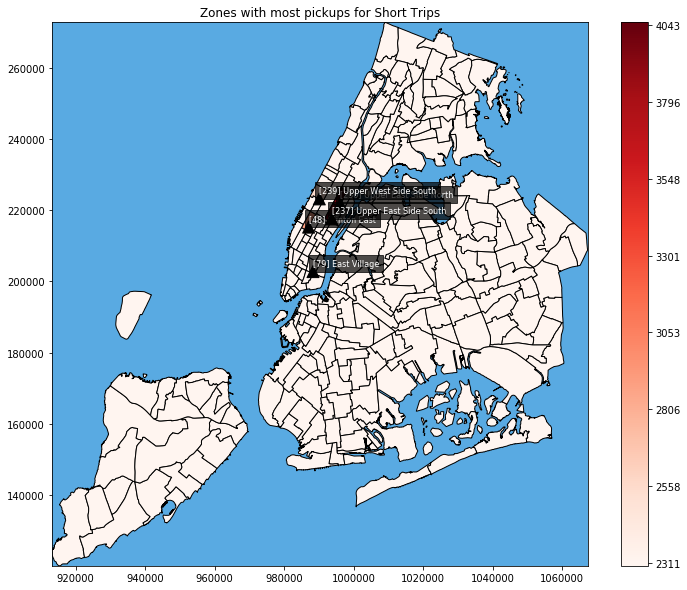

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
ax = plt.subplot(1, 1, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZonesShape, heat=countList, text=intraZone.LocationID.tolist())

### Show top 5 short distance trip

In [106]:
top5Short = taxiSample[taxiSample.trip_distance<20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Short.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Short['Pick-Up-Zone']=puZones
top5Short['Pick-Up-Borough']=puBoroughs
top5Short['Drop-Off-Zone']=doZones
top5Short['Drop-Off-Borough']=doBoroughs
top5Short

PULocationID  DOLocationID  count           Pick-Up-Zone  \
15705           237           236   4457  Upper East Side South   
15706           237           237   4043  Upper East Side South   
15519           236           236   3990  Upper East Side North   
15520           236           237   3814  Upper East Side North   
15980           239           142   3456  Upper West Side South   

      Pick-Up-Borough          Drop-Off-Zone Drop-Off-Borough  
15705       Manhattan  Upper East Side North        Manhattan  
15706       Manhattan  Upper East Side South        Manhattan  
15519       Manhattan  Upper East Side North        Manhattan  
15520       Manhattan  Upper East Side South        Manhattan  
15980       Manhattan    Lincoln Square East        Manhattan

### Show top 5 long distance trip

In [107]:
top5Long = taxiSample[taxiSample.trip_distance>=20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Long.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Long['Pick-Up-Zone']=puZones
top5Long['Pick-Up-Borough']=puBoroughs
top5Long['Drop-Off-Zone']=doZones
top5Long['Drop-Off-Borough']=doBoroughs
top5Long

PULocationID  DOLocationID  count Pick-Up-Zone Pick-Up-Borough  \
566           132           239    387  JFK Airport          Queens   
565           132           238    352  JFK Airport          Queens   
463           132            87    268  JFK Airport          Queens   
496           132           142    247  JFK Airport          Queens   
525           132           181    225  JFK Airport          Queens   

                Drop-Off-Zone Drop-Off-Borough  
566     Upper West Side South        Manhattan  
565     Upper West Side North        Manhattan  
463  Financial District North        Manhattan  
496       Lincoln Square East        Manhattan  
525                Park Slope         Brooklyn

### Which region is the most expensive? (totalCost/totalDistance)

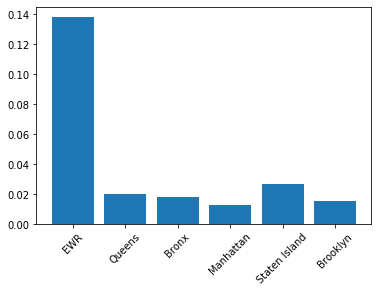

In [108]:
expenseRatio = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    expenseRatio[borough]=totalRideBorough['total_amount'].sum()/totalRideBorough['trip_duration'].sum()
    
plt.bar(range(len(expenseRatio)), list(expenseRatio.values()), align='center')
plt.xticks(range(len(expenseRatio)), list(expenseRatio.keys()), rotation=45)

plt.show()

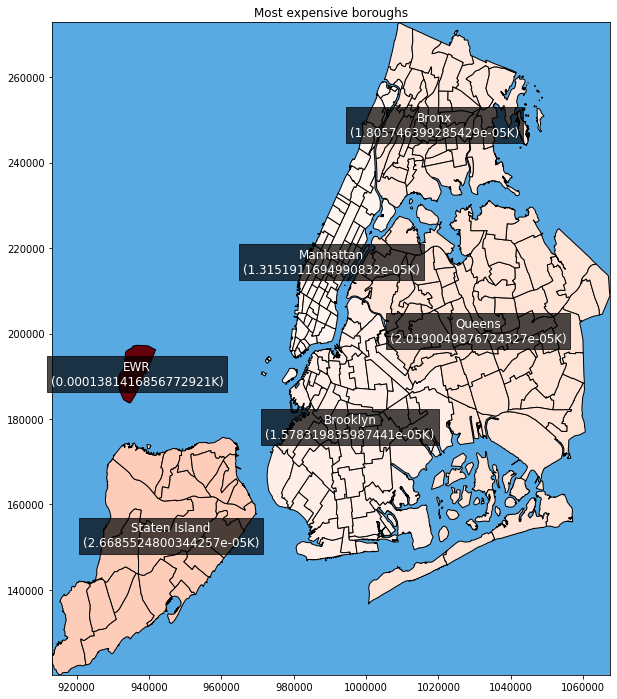

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
ax = plt.subplot(1, 1, 1)
ax.set_title("Most expensive boroughs")
draw_region_map(ax, taxiZonesShape, heat = expenseRatio)

### Which region has the most traffic? (tripDuration/tripDistance)

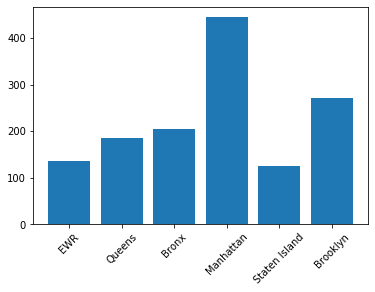

In [110]:
trafficRatio = dict()
for borough in boroughs:
    boroughLocationId = taxiZone[taxiZone.borough==borough].rename(columns={'LocationID':'PULocationID'})
    totalRideBorough = taxiSample.merge(boroughLocationId, on='PULocationID', how='inner')
    trafficRatio[borough]=totalRideBorough['trip_duration'].sum()/totalRideBorough['trip_distance'].sum()
    
plt.bar(range(len(trafficRatio)), list(trafficRatio.values()), align='center')
plt.xticks(range(len(trafficRatio)), list(trafficRatio.keys()), rotation=45)

plt.show()

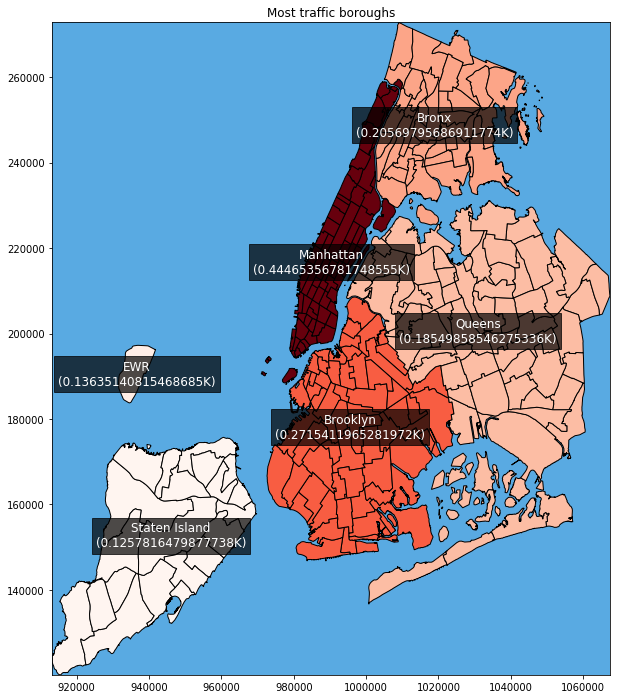

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,12))
ax = plt.subplot(1, 1, 1)
ax.set_title("Most traffic boroughs")
draw_region_map(ax, taxiZonesShape, heat = trafficRatio)

In [112]:
print("It took %s seconds to process" % (time.time() - startTime))

It took 81.04165506362915 seconds to process
